## **📝 Instructions**
Water detection system
This project is going to be done at Kaggle. Kaggle is known for organizing data science competitions in which individuals and teams can compete to create the best model on a variety of tasks.

Specifically, we will explore a competition that has now ended, which rewarded the top performers with $25,000, distributed to the top four solutions.

### **Step 1: Register or log in to Kaggle**
The first step to participate in a competition is to have a Kaggle account. Registration is very simple and versatile.

### **Step 2: Participate in the competition**
Although it is closed, you can still upload your solutions and compare yourself with the rest of the competitors in the ranking. By clicking here, you can access the competition, where the purpose is to predict the amount of water.

Read the information about the problem description, evaluation metrics, timeline and prizes. Once you have an overview of the competition, prepare the notebook with the code development and upload it. Compare yourself with the other developers.

Follow these tips:

Look at the solutions proposed by other developers. Some use time series, others use supervised algorithms such as linear regression, decision trees, etc. Investigate which model might work best for this use case and explore all options.
Whatever model you choose, be sure to process and explore the data as studied in past modules.
Trial and error! Don't pretend to get the best model the first time, keep trying.

## **Challenge**
Can you build a story to predict the amount of water in each unique waterbody? The challenge is to determine how features influence the water availability of each presented waterbody. To be more straightforward, gaining a better understanding of volumes, they will be able to ensure water availability for each time interval of the year.

The time interval is defined as day/month depending on the available measures for each waterbody. Models should capture volumes for each waterbody(for instance, for a model working on a monthly interval a forecast over the month is expected).

The desired outcome is a notebook that can generate four mathematical models, one for each category of waterbody (acquifers, water springs, river, lake) that might be applicable to each single waterbody.

In [1]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import math

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from datetime import datetime, date 

#Facebook prophet
from prophet import Prophet

from keras.models import Sequential
from keras.layers import Dense, LSTM

2024-11-11 23:00:15.564661: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-11 23:00:15.802149: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-11 23:00:15.986128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731366016.263686     976 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731366016.342223     976 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 23:00:17.020156: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
# Step 1: Import data
df_raw = pd.read_csv("../data/raw/Aquifer_Petrignano.csv")
df_raw.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  5223 non-null   object 
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64
 2   Depth_to_Groundwater_P24              5168 non-null   float64
 3   Depth_to_Groundwater_P25              5184 non-null   float64
 4   Temperature_Bastia_Umbra              4199 non-null   float64
 5   Temperature_Petrignano                4199 non-null   float64
 6   Volume_C10_Petrignano                 5025 non-null   float64
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64
dtypes: float64(7), object(1)
memory usage: 326.6+ KB


In [4]:
# In the data explanation, they indicate that for 'Aquifer Petrignano' the following columns should be removed ('Depth_to_Groundwater_P24', 'Temperature_Petrignano'), these columns must be predicted
# Another explanation is that both rainfall and temperature affect characteristics such as level, flow, groundwater depth, and hydrometry some time after they fall.
df_interim = df_raw.copy()
df_interim = df_interim.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)
df_interim = df_interim[df_interim.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
df_interim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4199 entries, 0 to 4198
Data columns (total 6 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  4199 non-null   object 
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64
 2   Depth_to_Groundwater_P25              4172 non-null   float64
 3   Temperature_Bastia_Umbra              4199 non-null   float64
 4   Volume_C10_Petrignano                 4198 non-null   float64
 5   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64
dtypes: float64(5), object(1)
memory usage: 197.0+ KB


In [5]:
# Clean columns name
df_interim.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

targets = ['depth_to_groundwater']
features = [feature for feature in df_interim.columns if feature not in targets]
df = df_interim.copy()
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4199 entries, 0 to 4198
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  4199 non-null   object 
 1   rainfall              4199 non-null   float64
 2   depth_to_groundwater  4172 non-null   float64
 3   temperature           4199 non-null   float64
 4   drainage_volume       4198 non-null   float64
 5   river_hydrometry      4199 non-null   float64
dtypes: float64(5), object(1)
memory usage: 197.0+ KB


In [7]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
1,2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
2,2009-01-03,0.0,-31.07,4.4,-25766.208,2.4
3,2009-01-04,0.0,-31.05,0.8,-27919.296,2.4
4,2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3


/tmp/ipykernel_976/1685659465.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
/tmp/ipykernel_976/1685659465.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
/tmp/ipykernel_976/1685659465.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
/tmp/ipykernel_976/1685659465.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sns.lineplot(x=df['date'], y=df[co

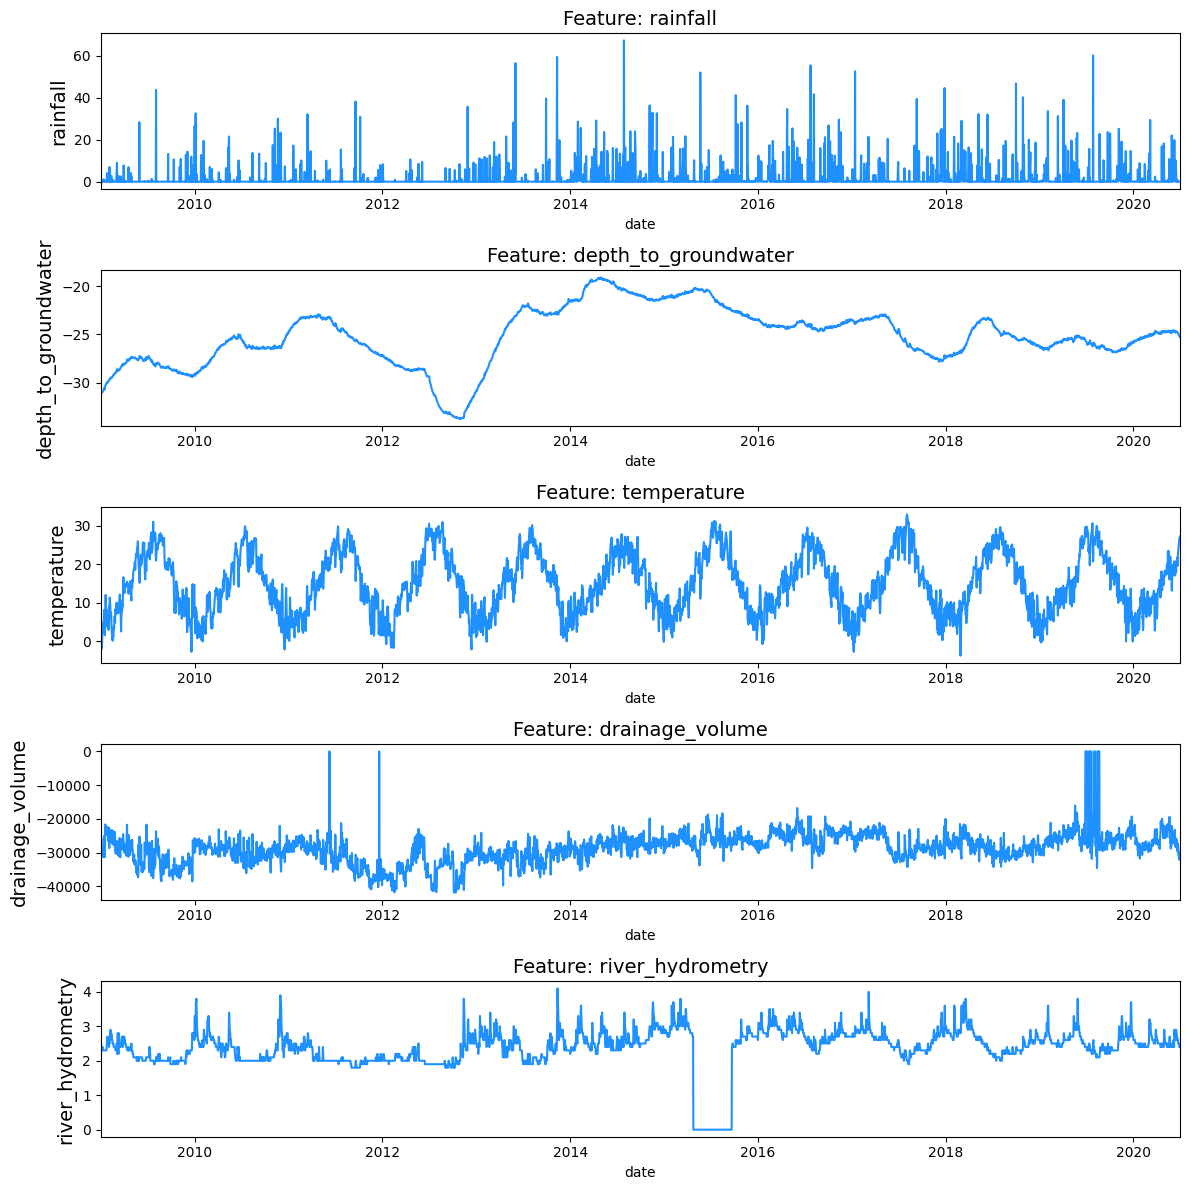

In [8]:
# River_hydrometry
fig, ax = plt.subplots(5, 1, figsize=(12, 12))

for i, column in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
                      
    ax[i].set_xlim([datetime(2009, 1, 1), datetime(2020, 6, 30)]) 

plt.tight_layout()
plt.show()

In [9]:
# Order values
df = df.sort_values(by='date').reset_index(drop=True)

In [10]:
# Check the equidistance of the timestamps
inter = df['date'].diff().dropna()
inter_unique = inter.unique()
if len(inter_unique) == 1:
    print('Equidistance')
else:
    print('Not equidistance')

Equidistance


In [11]:
# Check for null values
df.isna().sum()

date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
dtype: int64

/tmp/ipykernel_976/1109562917.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sns.lineplot(x=df['date'], y=df['river_hydrometry'].fillna(method='ffill'), ax=ax[0], color='blue', label='modify')
/tmp/ipykernel_976/1109562917.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(method='ffill'), ax=ax[1], color='blue', label='modify')


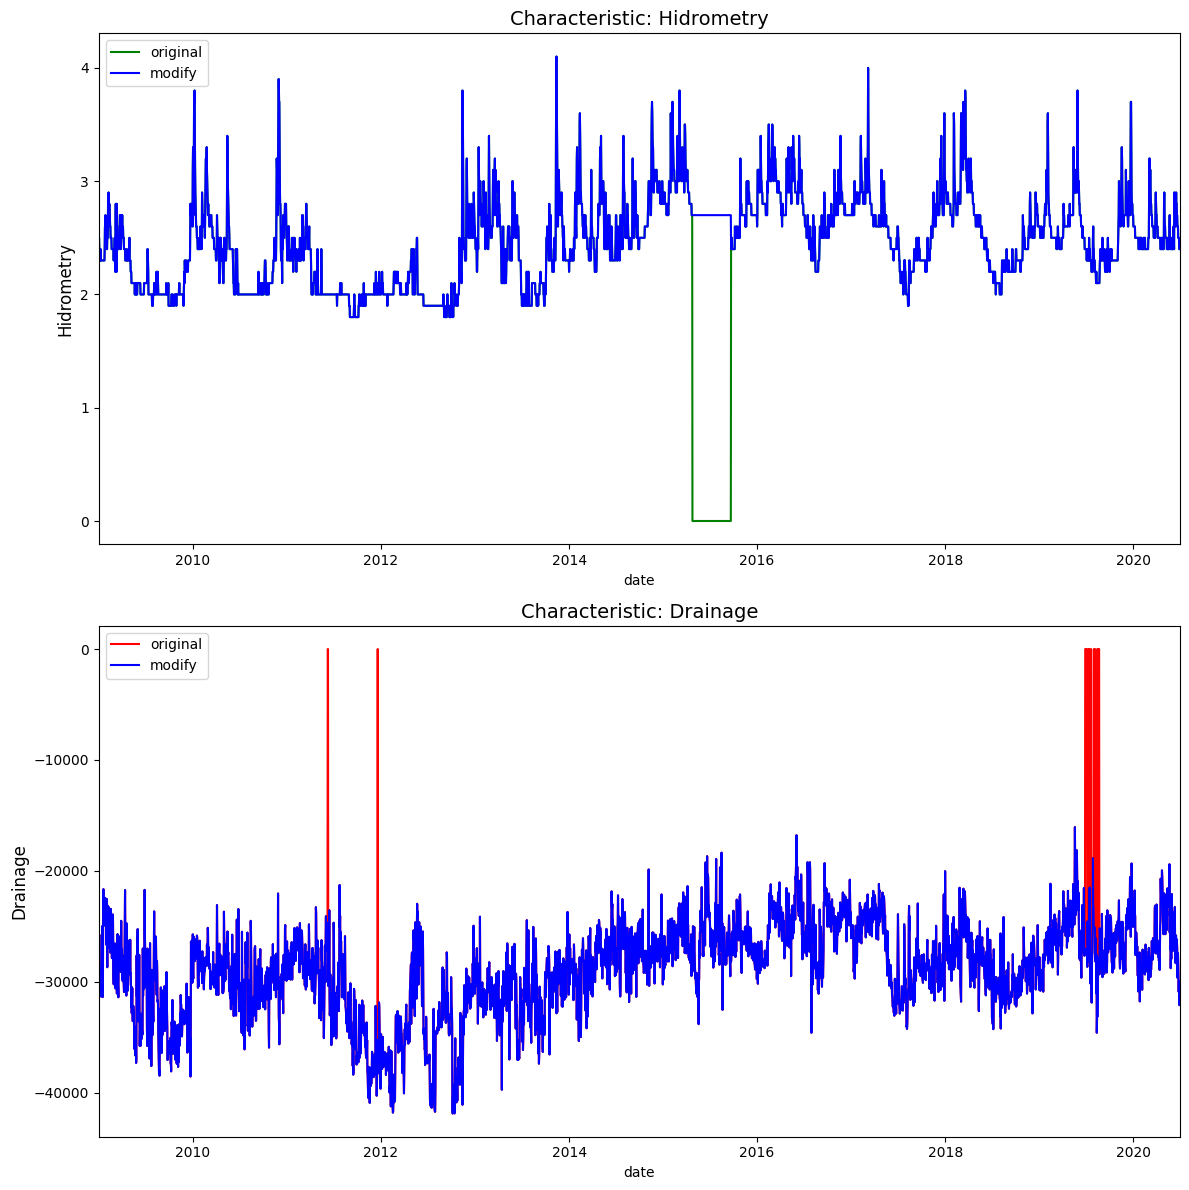

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

hidrometry = df['river_hydrometry'].copy()
df['river_hydrometry'] = df['river_hydrometry'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=hidrometry, ax=ax[0], color='green', label='original')
sns.lineplot(x=df['date'], y=df['river_hydrometry'].fillna(method='ffill'), ax=ax[0], color='blue', label='modify')
ax[0].set_title('Characteristic: Hidrometry', fontsize=14)
ax[0].set_ylabel('Hidrometry', fontsize=12)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
ax[0].legend(loc='upper left')

drainage = df['drainage_volume'].copy()
df['drainage_volume'] = df['drainage_volume'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=drainage, ax=ax[1], color='red', label='original')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(method='ffill'), ax=ax[1], color='blue', label='modify')
ax[1].set_title('Characteristic: Drainage', fontsize=14)
ax[1].set_ylabel('Drainage', fontsize=12)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
ax[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

Now we need to fix the missing values. Let's review these cases and see what we can do about them.

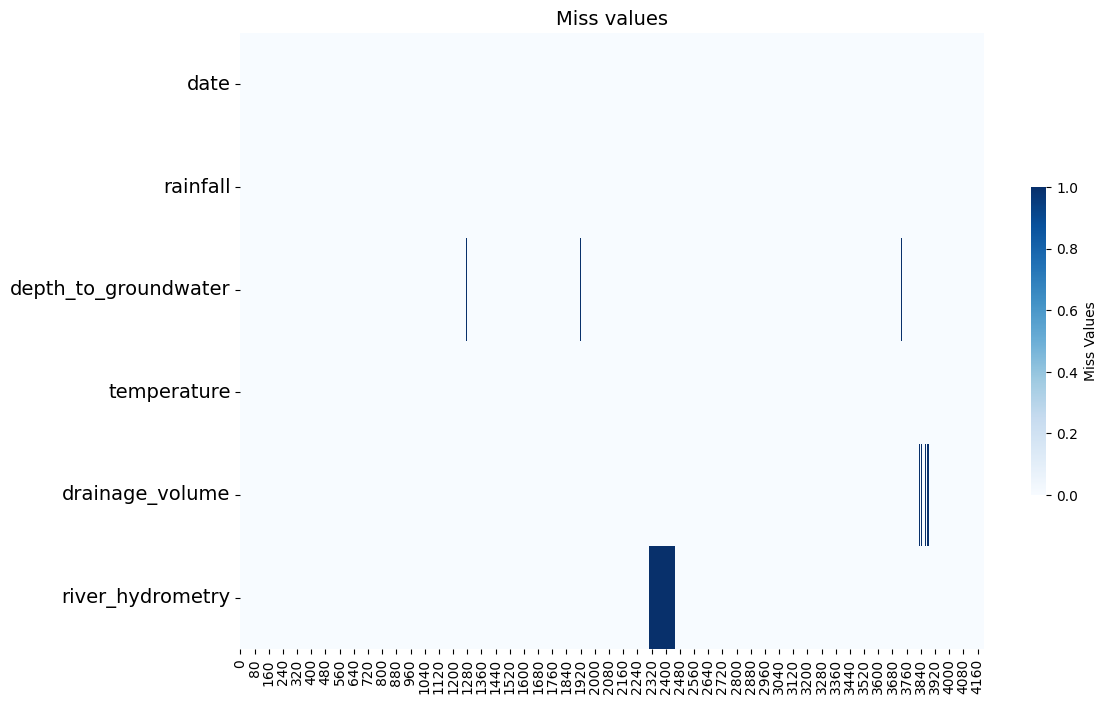

In [13]:
plt.figure(figsize=(12, 8))

sns.heatmap(df.T.isna(), cmap='Blues', cbar_kws={'shrink':0.5, 'label':'Miss Values'})
plt.title('Miss values', fontsize=14)
plt.yticks(fontsize=14)

plt.show()

### **Missing values, strategy**
**1. Remove Rows or Columns with NaN:** This removes any row that has at least one NaN value. Use this if the missing values ​​​​represent a small portion of the data and are not critical to the analysis.

**2. Fill Missing Values ​​​​(fillna):** Filling missing values ​​​​is useful if you can infer or approximate the missing values. Fill with a specific value; Fill with the last valid value (Forward Fill)
- **Fill NaN with the last valid value (.ffill())**
In this option, "forward fill" is applied, using the last valid value before each NaN.
- When to use it: It is useful in sequential or time series data, where it makes sense to assume that a value would remain constant until a new one is recorded.
- Advantages:
    - Maintains continuity in time series.
    - Easy to interpret in time series or sequential data streams.
- Disadvantages:
    - Can result in over-extension of previous values ​​if NaNs occur in consecutive groups.
    - Not ideal for rapidly changing data as it can introduce significant errors.

- **Padding NaNs with mean value**
NaN values ​​are replaced by the column average.
- When to use it: This method is common in numerical data when NaN values ​​are few and scattered. However, as you indicate, it is a simple option that can be naive and not reflect real patterns.
- Advantages:
    - Does not alter the mean of the data, which can be useful for simple aggregate analysis.
    - Simple to implement and fast.
- Disadvantages:
    - Ignores temporal or contextual patterns in the data.
    - Reduces variability in the data, which can skew the analysis.

**3. Interpolation of Missing Values:** Interpolation calculates intermediate values ​​​​between valid data. It is especially useful in time series.
- **Fill NaNs with linear interpolation (.interpolate())**
This method uses linear interpolation to estimate intermediate values ​​between known points, which helps to generate a smooth transition between values ​​before and after the NaNs.
- When to use it: It is the best choice for time series when the values ​​are continuous and the change between points is not too abrupt.
- Advantages:
    - Maintains a more realistic continuity between values ​​before and after the NaNs.
    - Useful for time series with smooth variations, where linear interpolation is a good approximation.
- Disadvantages:
    - Requires neighboring values ​​to do the interpolation, which is not possible in the case of NaN values ​​at the beginning or end of the series.
    - If the data is very non-linear, it can result in estimation errors.

**4. Model-Based Fill:** In advanced situations, you can use predictive models to estimate missing values. For example:
- Regression: Use the other columns as independent variables to predict the missing values ​​​​in a column.
- Multiple Imputation: Techniques such as IterativeImputer in scikit-learn create multiple imputations based on models and select the most likely one.
- K-Nearest Neighbors (KNN) Imputation: Uses values ​​​​from similar observations to estimate the missing value.

**5. Pad NaN with an outlier (such as -999 or np.inf):**
In this option, NaN values ​​are padded with a number that would not be expected in the data range, such as -999 or np.inf, to indicate that these values ​​are actually "false" or "flags".
- When to use it: This option can be useful if you just want to label NaN values ​​without removing them and you want these values ​​to stand out clearly in the analysis.
- Advantages:
    - Helps to differentiate missing values ​​without erasing them.
    - Easy to implement and visually identify in exploratory analysis.
- Disadvantages:
    - May introduce problems in statistical analysis or models, as these extreme values ​​will affect the means and deviations.
    - Machine learning models could interpret these values ​​as real data

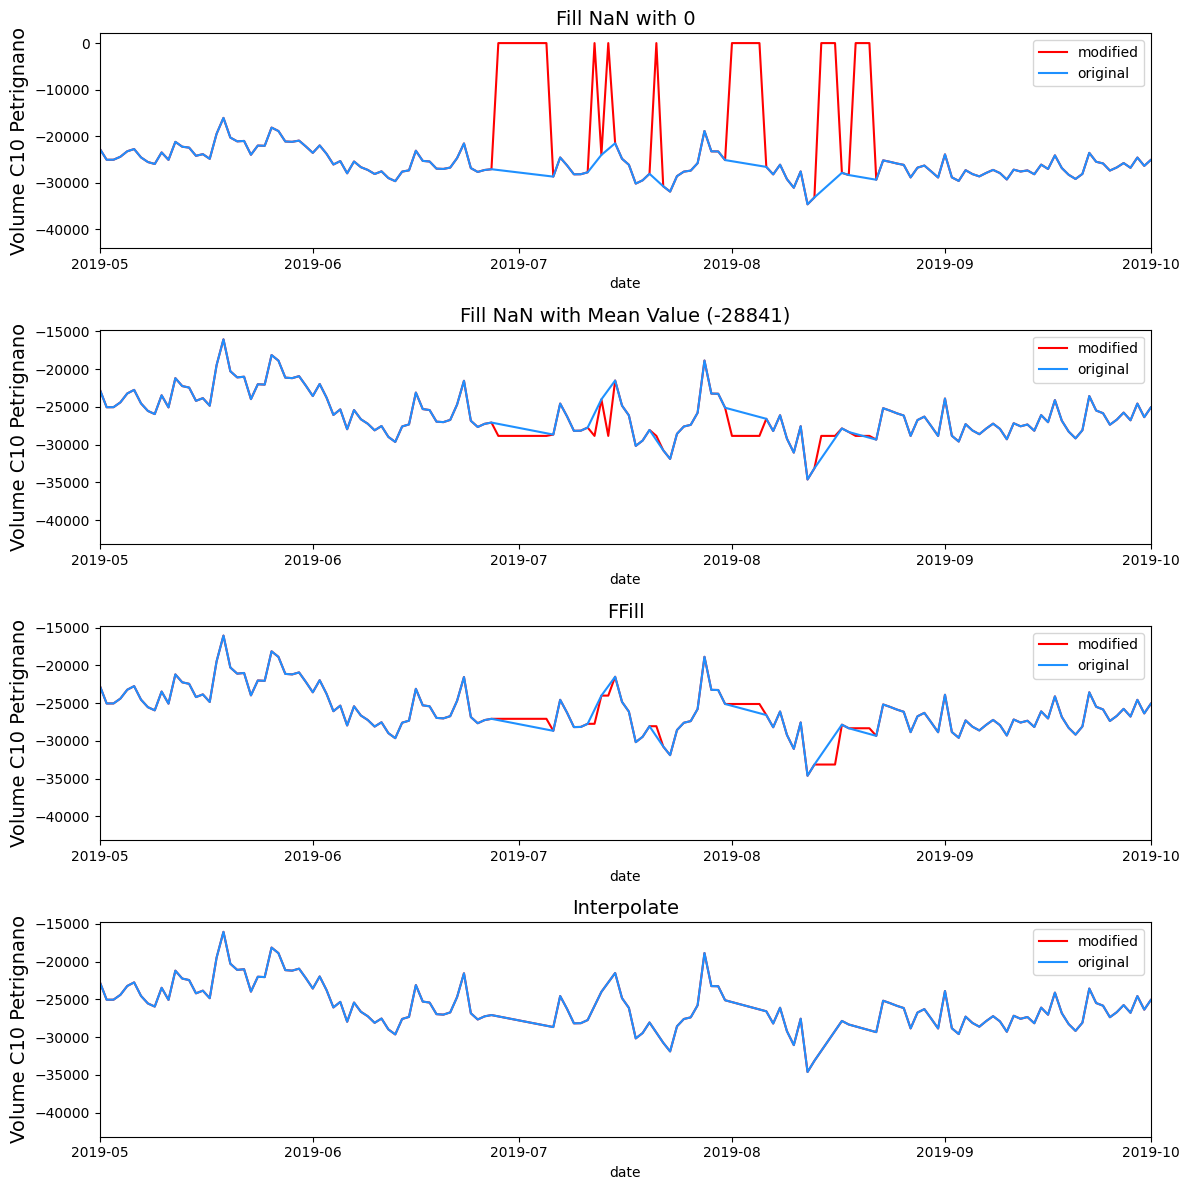

In [14]:
# We use for alternatives: Replace NaN with 0, mean, ffill, interpolate
fig, ax = plt.subplots(4, 1, figsize=(12, 12))

fill_methods = [
    ('fillna(0)', df['drainage_volume'].fillna(0), 'Fill NaN with 0'),
    ('fillna(mean)', df['drainage_volume'].fillna(df['drainage_volume'].mean()), f'Fill NaN with Mean Value ({df["drainage_volume"].mean():.0f})'),
    ('ffill()', df['drainage_volume'].ffill(), 'FFill'),
    ('interpolate()', df['drainage_volume'].interpolate(), 'Interpolate')
]

# Plot
for i, (method, filled_data, title) in enumerate(fill_methods):
    sns.lineplot(x=df['date'], y=filled_data, ax=ax[i], color='red', label='modified')
    sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[i], color='dodgerblue', label='original')
    ax[i].set_title(title, fontsize=14)
    ax[i].set_ylabel('Volume C10 Petrignano', fontsize=14)
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])

plt.tight_layout()
plt.show()

**Conclusion**
It can be observed that the interpolation option is the one that best fits.

In [15]:
df['drainage_volume'] = df['drainage_volume'].interpolate()
df['river_hydrometry'] = df['river_hydrometry'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()

### Check resampling

/tmp/ipykernel_976/2037873240.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.resample('M', on='date')[col].agg(agg_func).reset_index()
/tmp/ipykernel_976/2037873240.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.resample('M', on='date')[col].agg(agg_func).reset_index()


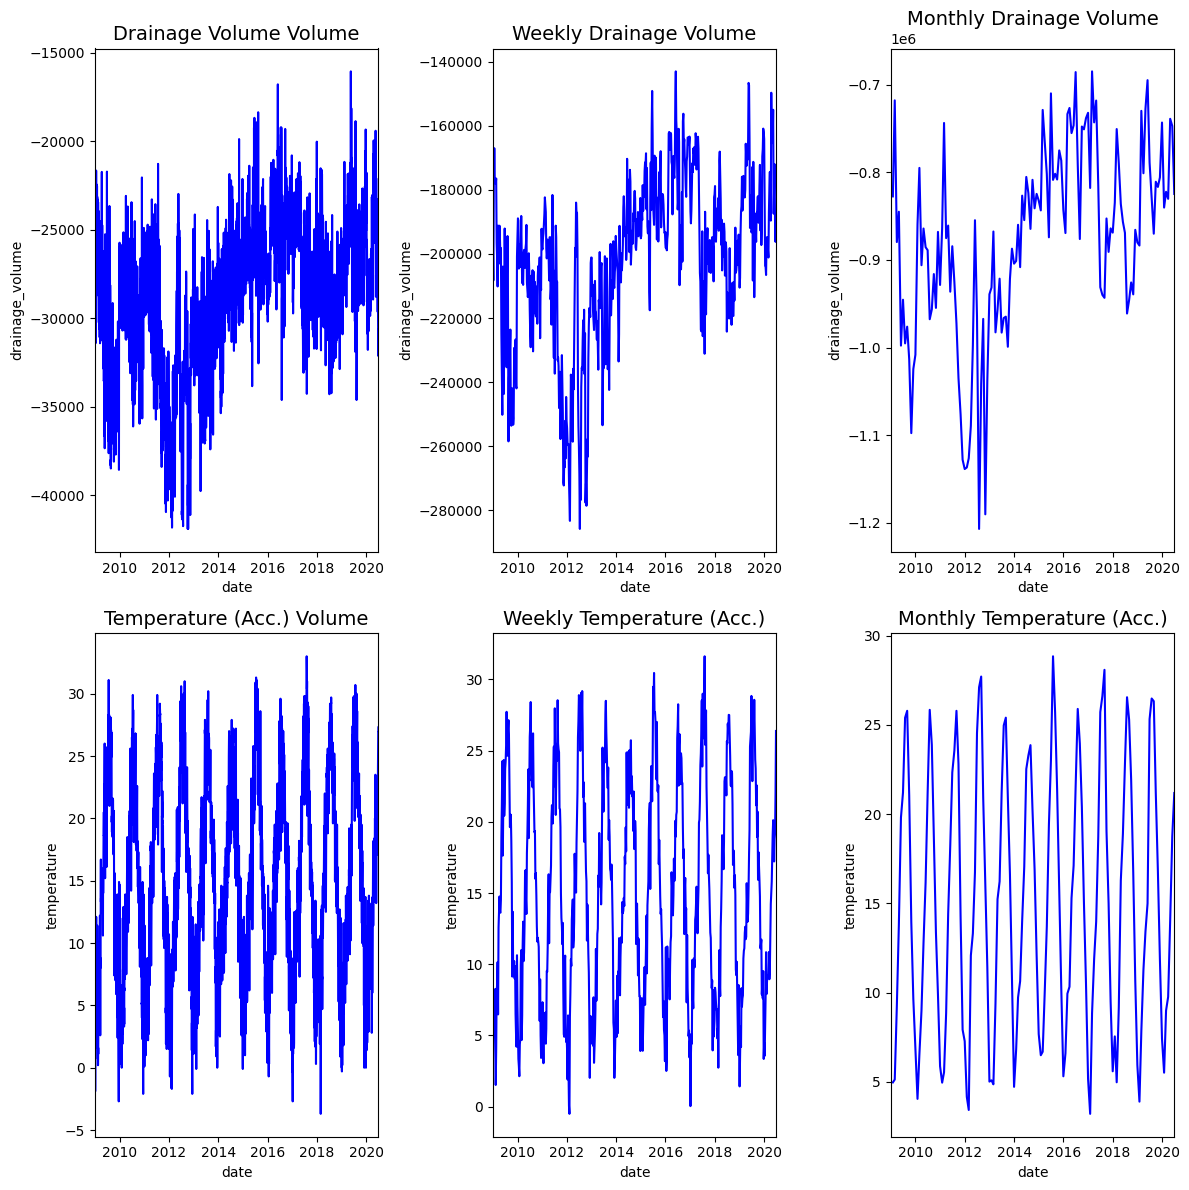

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(12, 12))

# Function to plot series and resampled
def plot_resampled_series(df, col, agg_func, ax_row, ylabel):
    # Data serie
    sns.lineplot(x=df['date'], y=df[col], color='blue', ax=ax[ax_row, 0])
    ax[ax_row, 0].set_title(f'{ylabel} Volume', fontsize=14)

    # Resampled week
    weekly = df.resample('7D', on='date')[col].agg(agg_func).reset_index()
    sns.lineplot(x=weekly['date'], y=weekly[col], color='blue', ax=ax[ax_row, 1])
    ax[ax_row, 1].set_title(f'Weekly {ylabel}', fontsize=14)

    # Resampled month
    monthly = df.resample('M', on='date')[col].agg(agg_func).reset_index()
    sns.lineplot(x=monthly['date'], y=monthly[col], color='blue', ax=ax[ax_row, 2])
    ax[ax_row, 2].set_title(f'Monthly {ylabel}', fontsize=14)

# Plot
plot_resampled_series(df, 'drainage_volume', 'sum', 0, 'Drainage Volume')
plot_resampled_series(df, 'temperature', 'mean', 1, 'Temperature (Acc.)')

# Configure limits for subplots
for ax_row in ax:
    for subplot in ax_row:
        subplot.set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

In [17]:
# Reducing the resolution to weekly may smooth out the data and help with analysis.
downsample = df[['date',
                 'depth_to_groundwater', 
                 'temperature',
                 'drainage_volume', 
                 'river_hydrometry',
                 'rainfall'
                ]].resample('7D', on='date').mean().reset_index(drop=False)

df = downsample.copy()

### **Stationary**

Checking for stationarity in a time series can be done through three different approaches:

1. Visual Analysis: This involves plotting the time series and observing whether there are trend or seasonality patterns. A stationary series should show stable behavior over time, with no increasing or decreasing trends or seasonal patterns.

2. Basic Statistics: This method involves dividing the time series into several partitions and comparing the mean and variance of each segment. If the series is stationary, the mean and variance should remain approximately constant in each partition.

3. Statistical Tests: One of the most common tests is the Augmented Dickey-Fuller Test (ADF), which tests for the presence of unit roots in the series. A significant result from this test indicates that the series is stationary.

These three approaches provide different perspectives for assessing stationarity and are useful in combination to obtain a more robust conclusion.

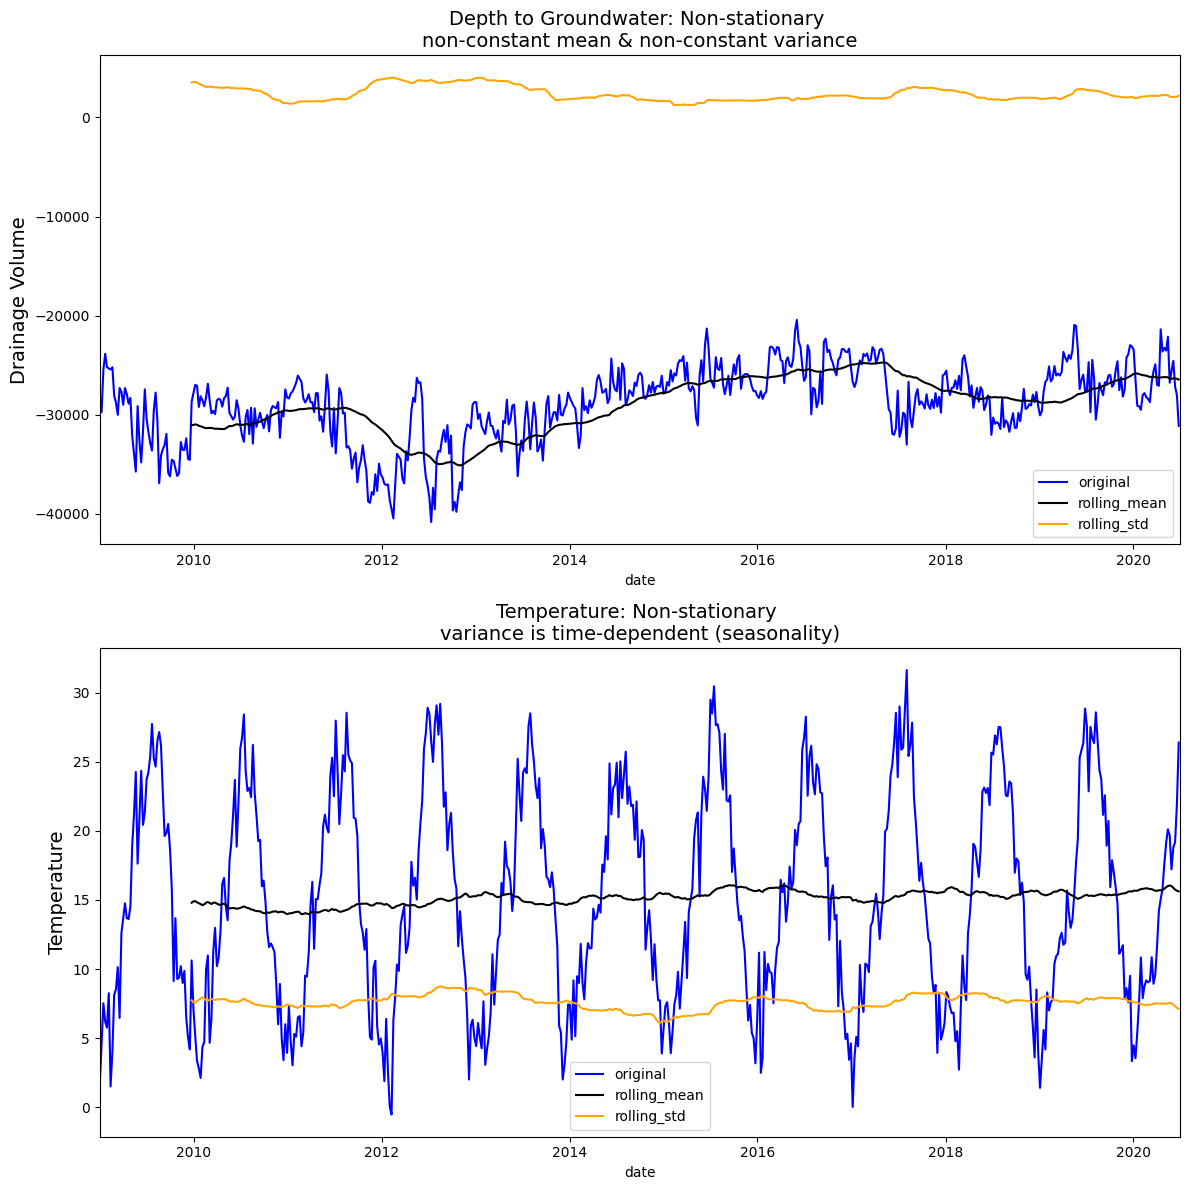

In [18]:
# Rolling window
rolling_window = 52

# Figure configuration
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# Function
def plot_series_with_rolling(ax, x, y, y_label, title):
    sns.lineplot(x=x, y=y, ax=ax, color='blue', label='original')
    sns.lineplot(x=x, y=y.rolling(rolling_window).mean(), ax=ax, color='black', label='rolling_mean')
    sns.lineplot(x=x, y=y.rolling(rolling_window).std(), ax=ax, color='orange', label='rolling_std')
    ax.set_title(title, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    ax.set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax.legend()

# Plot Drainage Volume
plot_series_with_rolling(
    ax[0],
    x=df['date'],
    y=df['drainage_volume'],
    y_label='Drainage Volume',
    title='Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance'
)

# Plot Temperature
plot_series_with_rolling(
    ax[1],
    x=df['date'],
    y=df['temperature'],
    y_label='Temperature',
    title='Temperature: Non-stationary \nvariance is time-dependent (seasonality)'
)

plt.tight_layout()
plt.show()

Visually we can observe that the characteristics do not have constant mean and std, but are close to them.

**The unit root test** is a method used in time series to identify whether a series is non-stationary. The presence of a unit root indicates that the time series has a trend over time, making it non-stationary.

The Augmented Dickey-Fuller (ADF) test is one of the most common unit root tests. This test assesses whether a unit root exists in the series, which occurs when the value of the parameter 𝛼 α is equal to 1 in the following equation:

`Yt = αYt−1 + Xt`

where:

- Yt is the value of the time series at time t𝑡,
- Xt​ represents an exogenous variable, such as a trend term or a seasonal component.
When a unit root is detected (i.e. α=1), it means that the series is not stationary, as it exhibits a persistent trend or changes in its mean and variance over time.


The Augmented Dickey-Fuller (ADF) test is a statistical test used to detect unit roots, which are a cause of non-stationarity in time series data.

**Hypotheses of the ADF Test**
- Null Hypothesis (H0): The time series has a unit root, meaning it is non-stationary.
- Alternative Hypothesis (H1): The time series does not have a unit root, meaning it is stationary.

If we reject the null hypothesis, we can conclude that the time series is stationary.

**Criteria for Rejecting the Null Hypothesis**
There are two main ways to decide whether to reject the null hypothesis in the ADF test:

**p-value:**

- p-value > significance level (typically 0.05): We do not reject the null hypothesis, indicating that the data has a unit root and is non-stationary.
- p-value ≤ significance level (typically 0.05): We reject the null hypothesis, indicating that the data does not have a unit root and is stationary.

**Comparison of the ADF test statistic with critical values:**

- ADF statistic > critical value: We do not reject the null hypothesis, suggesting that the data has a unit root and is non-stationary.
- ADF statistic < critical value: We reject the null hypothesis, suggesting that the data does not have a unit root and is stationary.

In summary, if the p-value is low or if the ADF statistic is less than the critical value, we can reject the null hypothesis and conclude that the series is stationary.

In [19]:
result = adfuller(df['depth_to_groundwater'].values)
result

(np.float64(-2.8802016493166605),
 np.float64(0.047699190920208856),
 7,
 592,
 {'1%': np.float64(-3.441444394224128),
  '5%': np.float64(-2.8664345376276454),
  '10%': np.float64(-2.569376663737217)},
 np.float64(-734.3154255877616))

Each value has a specific meaning:

1. ADF Statistic (-2.8802016493166605):

This is the value of the ADF test statistic. It is used to compare against the critical values to determine if we should reject the null hypothesis. The more negative the ADF statistic, the more likely we are to reject the null hypothesis and conclude that the series is stationary.

2. p-value (0.047699190920208856):

This is the p-value of the test. If the p-value is less than or equal to a typical significance level (e.g., 0.05), we reject the null hypothesis, indicating that the series is stationary. In this case, the p-value is approximately 0.0477, which is below 0.05, suggesting that we can reject the null hypothesis at the 5% level of significance and consider the series stationary.

3. Number of Lags Used (7):

This number indicates the number of lags of differences in the series that were used in the ADF model to control for autocorrelation in the series.

4. Number of Observations Used (592):

This is the number of observations effectively used in the test after accounting for the lags.

5. Critical Values ({'1%': -3.4414, '5%': -2.8664, '10%': -2.5694}):

These critical values serve as reference points for the ADF statistic at significance levels of 1%, 5%, and 10%.
In this case, the ADF statistic (-2.8802) is less than the 5% critical value (-2.8664), suggesting that we could reject the null hypothesis at the 5% level.

6. Akaike Information Criterion (AIC) Value (-734.3154255877616):

This is the Akaike Information Criterion (AIC) value, which is helpful for selecting the best model among several. While it doesn’t directly indicate stationarity, it can assist in model comparisons in other contexts.

**Conclusion**

Since:

The p-value (0.0477) is less than 0.05, and
The ADF statistic (-2.8802) is less than the 5% critical value (-2.8664),
we can reject the null hypothesis at the 5% significance level and conclude that the depth_to_groundwater series is stationary.

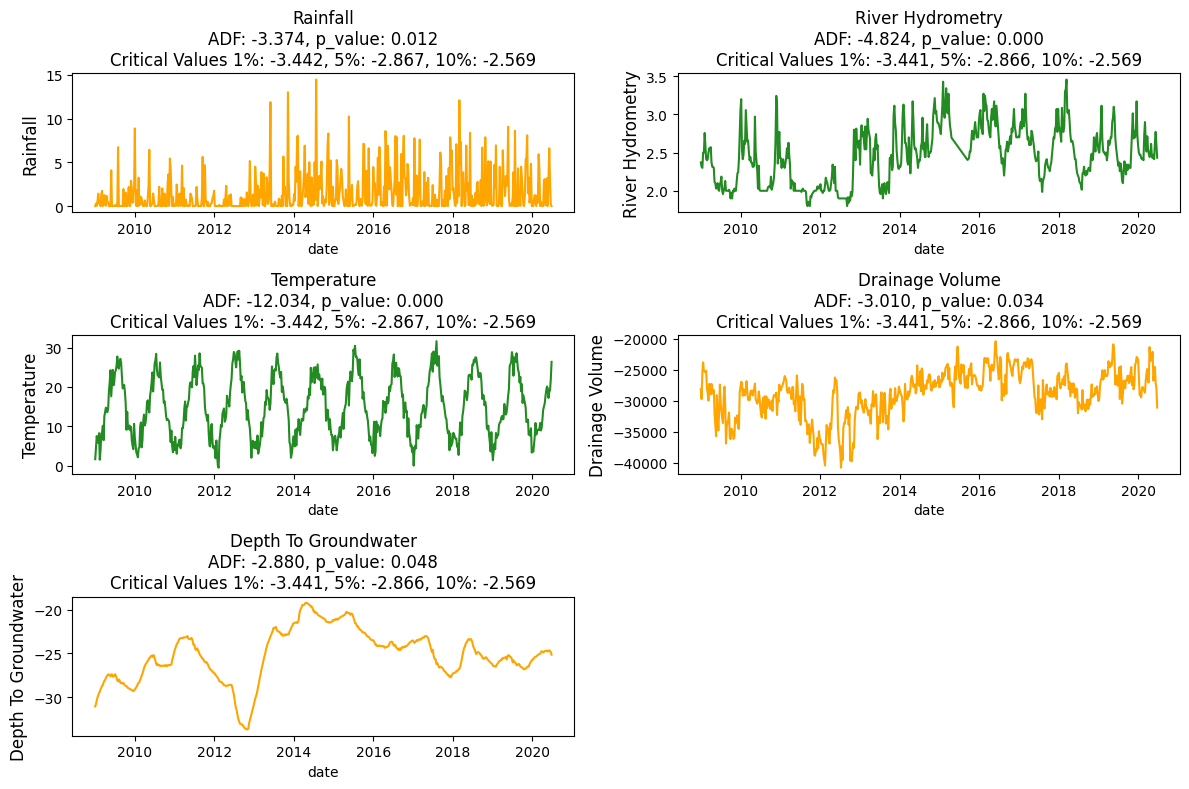

In [20]:
# Fig configuration
fig, ax = plt.subplots(3, 2, figsize=(12, 8))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    adf_stat, p_val = result[0], result[1]
    crit_values = result[4]

    if (p_val < 0.5) and (adf_stat < crit_values['1%']):
        linecolor = 'forestgreen'
    elif (p_val < 0.5) and (adf_stat < crit_values['5%']):
        linecolor = 'orange'
    elif (p_val < 0.5) and (adf_stat < crit_values['10%']):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'{title}\nADF: {adf_stat:.3f}, p_value: {p_val:.3f}\n' +
                 f'Critical Values 1%: {crit_values["1%"]:.3f}, 5%: {crit_values["5%"]:.3f}, 10%: {crit_values["10%"]:.3f}', 
                 fontsize=12)
    ax.set_ylabel(title, fontsize=12)

columns_to_plot = {
        (0, 0): 'rainfall',
    (1, 0): 'temperature',
    (0, 1): 'river_hydrometry',
    (1, 1): 'drainage_volume',
    (2, 0): 'depth_to_groundwater'
}

for (i, j), column in columns_to_plot.items():
    visualize_adfuller_results(df[column], title=column.replace('_', ' ').title(), ax=ax[i, j])


fig.delaxes(ax[2, 1])

plt.tight_layout()
plt.show()

If the data is non-stationary but we want to use a model like ARIMA (which requires stationarity), we need to transform the series to make it stationary.

The two most common methods for transforming a series to achieve stationarity are:

1. Transformation: Apply functions such as logarithm or square root to stabilize non-constant variance.
2. Differencing: Subtract the previous value from the current value to remove trends and achieve a constant mean.

### **Transforming**

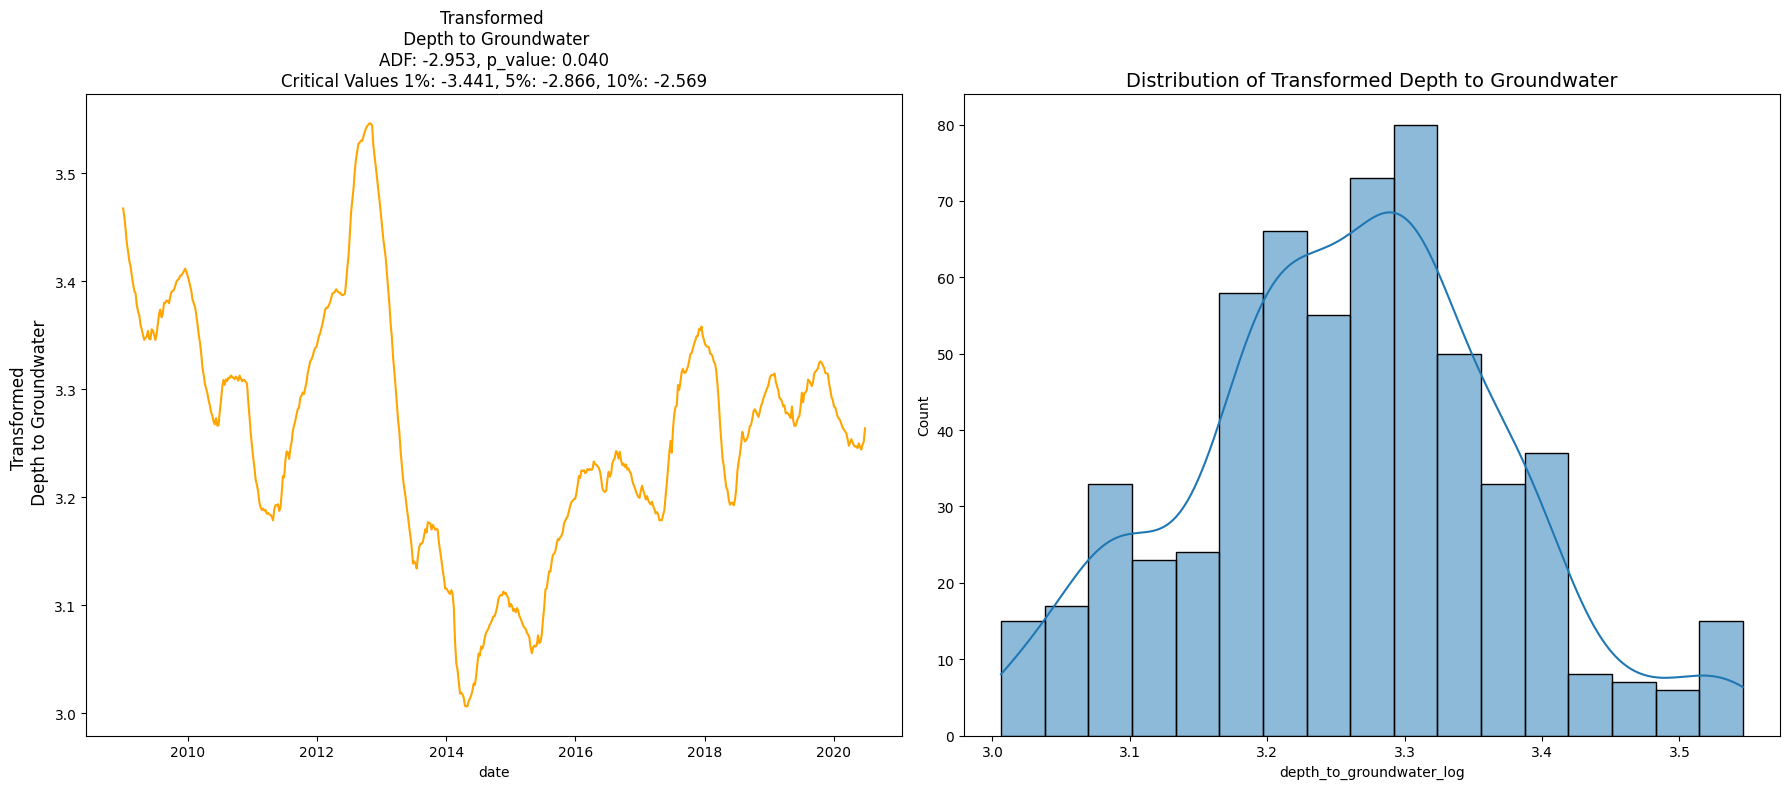

In [21]:
df['depth_to_groundwater_log'] = np.log(df['depth_to_groundwater'].abs() + 1)

fig, ax = plt.subplots(1, 2, figsize=(18, 8))
visualize_adfuller_results(df['depth_to_groundwater_log'], 'Transformed \n Depth to Groundwater', ax[0])
sns.histplot(df['depth_to_groundwater_log'], kde=True, ax=ax[1])
ax[1].set_title('Distribution of Transformed Depth to Groundwater', fontsize=14)
plt.tight_layout()
plt.show()

### **Differencing**

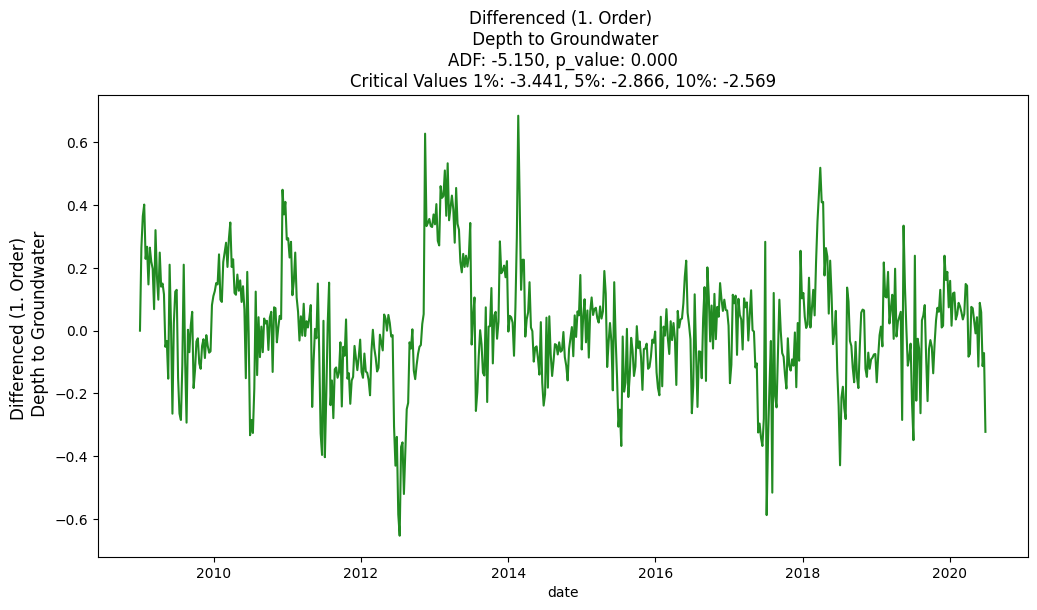

In [22]:
# First Order Differencing
ts_diff = np.diff(df['depth_to_groundwater'])
df['depth_to_groundwater_diff_1'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
visualize_adfuller_results(df['depth_to_groundwater_diff_1'], 'Differenced (1. Order) \n Depth to Groundwater', ax)


### **Feature engineering**

In [24]:
df['date'] = pd.to_datetime(df['date'])

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_year'] = df['date'].dt.dayofyear
df['week_of_year'] = df['date'].dt.isocalendar().week
df['quarter'] = df['date'].dt.quarter
df['season'] = df['month'] % 12 // 3 + 1

df[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

,date,year,month,day,day_of_year,week_of_year,quarter,season
0,2009-01-01,2009,1,1,1,1,1,1
1,2009-01-08,2009,1,8,8,2,1,1
2,2009-01-15,2009,1,15,15,3,1,1
3,2009-01-22,2009,1,22,22,4,1,1
4,2009-01-29,2009,1,29,29,5,1,1


### **Cyclic Feature Coding**

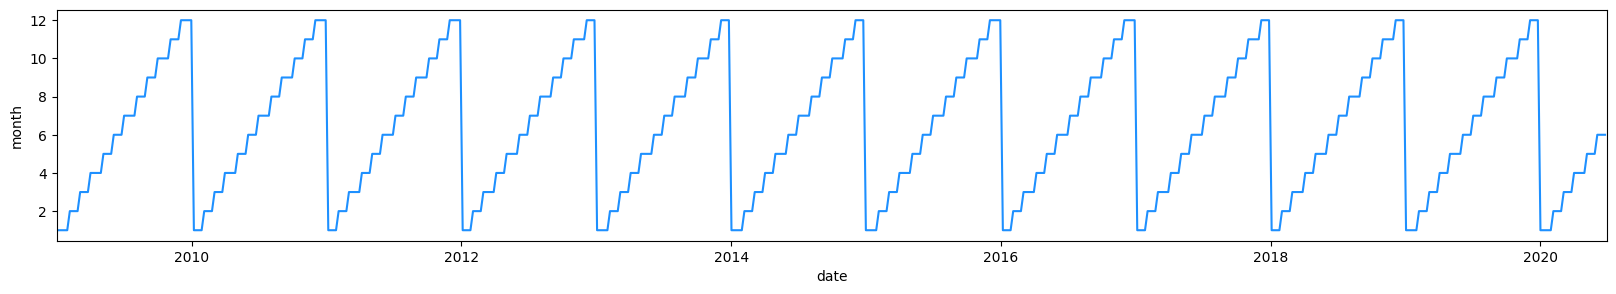

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(20, 3))

sns.lineplot(x=df['date'], y=df['month'], color='dodgerblue')
ax.set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()

Let's code this cyclic feature

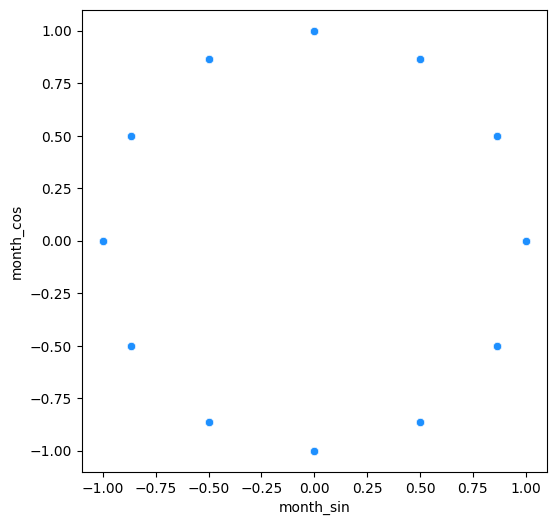

In [26]:
month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df['month']/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df['month']/month_in_year)

f, ax = plt.subplots(1, 1, figsize=(6, 6))

sns.scatterplot(x=df.month_sin, y=df.month_cos, color='dodgerblue')
plt.show()

### **Time series decomposition**

Time series decomposition involves breaking down a series into its component parts: level, trend, seasonality, and noise.

These components are defined as follows:

- Level: The average value of the series.
- Trend: The increasing or decreasing value in the series over time.
- Seasonality: The short-term repeating cycle in the series.
- Noise: The random variation in the series.

Decomposition provides a useful abstract model for understanding time series in general and for gaining insights into challenges during time series analysis and forecasting.

Every time series contains a level and noise. The trend and seasonality components are optional, depending on the characteristics of the series.

It is also helpful to consider how these components combine, either additively or multiplicatively:

- Additive: Each component is added to form the series.
- Multiplicative: Each component is multiplied to form the series.

In this case, we will use the `seasonal_decompose()` function from the `statsmodels` library to perform the decomposition.

In [27]:
core_columns =  ['rainfall', 'temperature', 'drainage_volume', 'river_hydrometry', 'depth_to_groundwater']

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

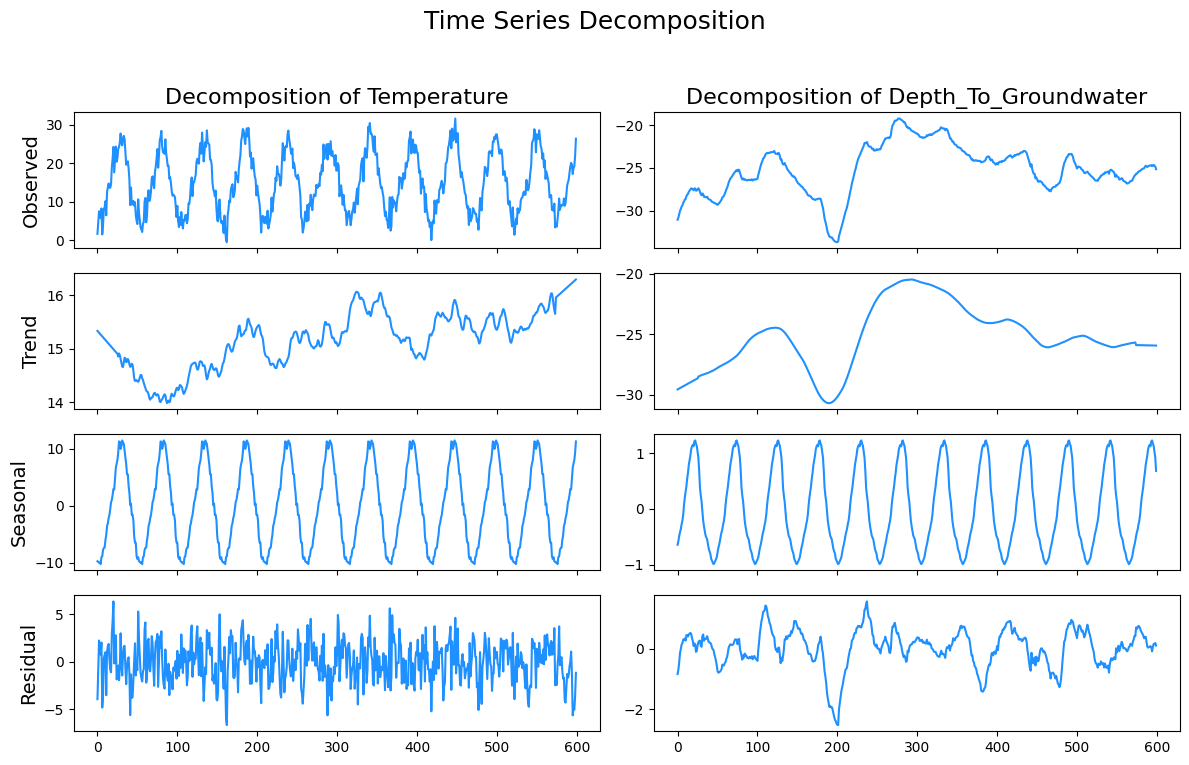

In [28]:
fig, ax = plt.subplots(4, 2, sharex=True, figsize=(12, 8))
fig.suptitle('Time Series Decomposition', fontsize=18)

for i,column in enumerate(['temperature', 'depth_to_groundwater']):
    res = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')

    components = [res.observed, res.trend, res.seasonal, res.resid]
    titles = ['Observed', 'Trend', 'Seasonal', 'Residual']

    for j, (component, title) in enumerate(zip(components, titles)):
        component.plot(ax=ax[j, i], legend=False, color='dodgerblue')
        if i == 0:
            ax[j, i].set_ylabel(title, fontsize=14)
        if j == 0:
            ax[j, i].set_title(f'Decomposition of {column.title()}', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### **Lag**
We want to calculate each variable with a shift() (lag) to compare the comparison with the other variables.

In [29]:
weeks_in_month = 4
shifts = {
    '_seasonal_shift_b_2m': -2 * weeks_in_month,
    '_seasonal_shift_b_1m': -1 * weeks_in_month,
    '_seasonal_shift_1m': 1 * weeks_in_month,
    '_seasonal_shift_2m': 2 * weeks_in_month,
    '_seasonal_shift_3m': 3 * weeks_in_month
}

for column in core_columns:
    for suffix, shift_value in shifts.items():
        df[f'{column}{suffix}'] = df[f'{column}_seasonal'].shift(shift_value)

### **EDA**

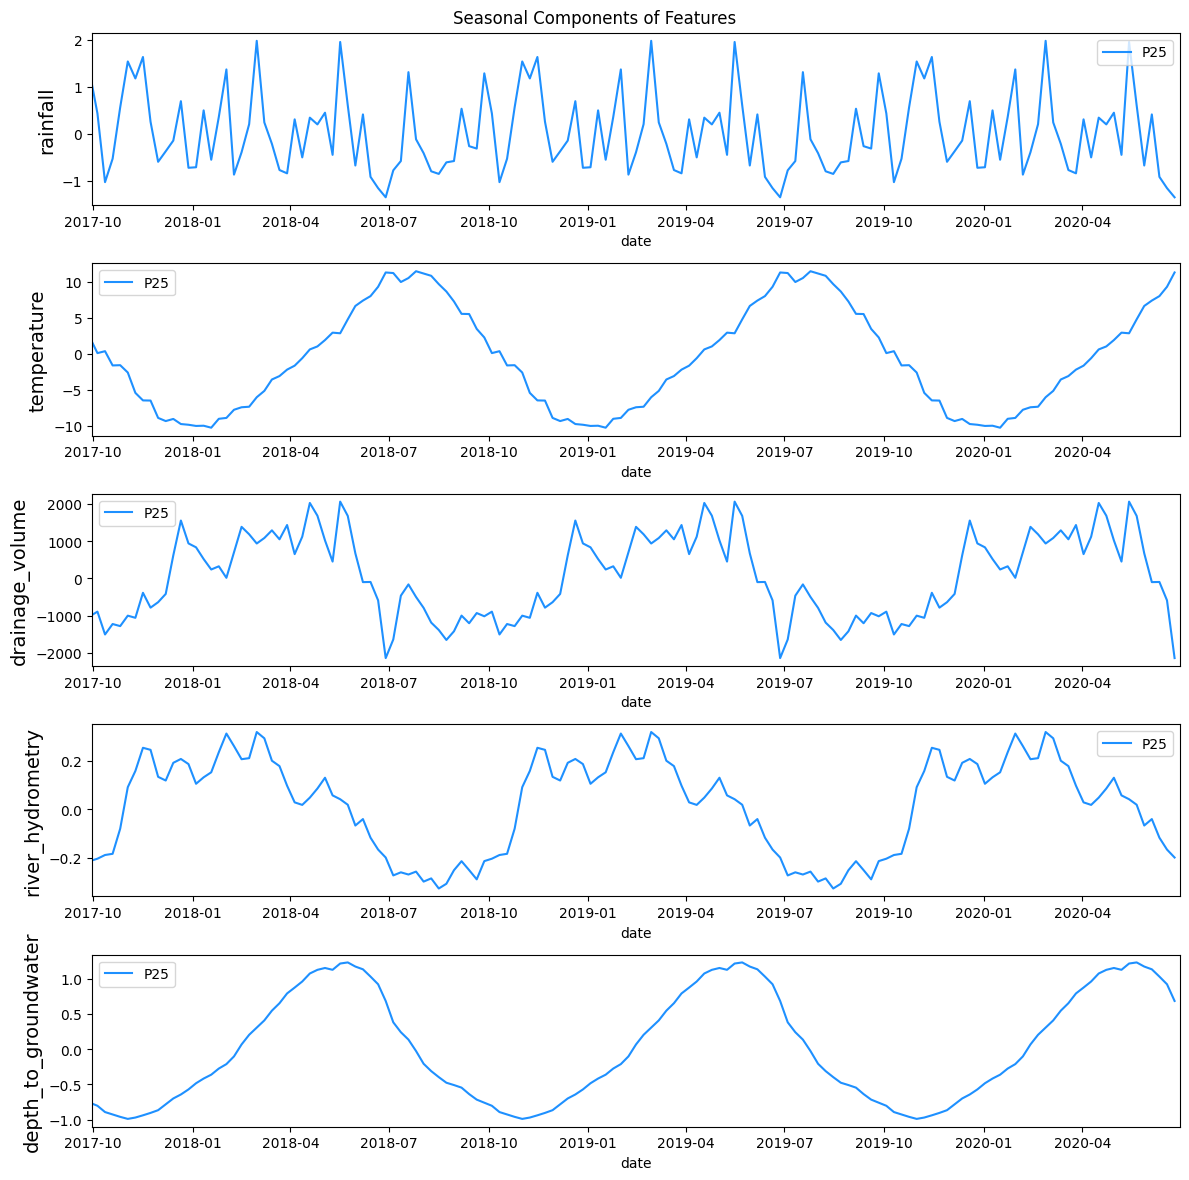

In [30]:
fig, ax = plt.subplots(5, 1, figsize=(12, 12))
fig.suptitle('Seasonal Components of Features', fontsize=12)

for i, column in enumerate(core_columns):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2017, 9, 30), date(2020, 6, 30)])
    
plt.tight_layout()
plt.show()

As we can see:

- depth_to_groundwater: reaches its maximum around May/June and its minimum around November
- temperature: reaches its maximum in August and its minimum in January
- drainage_volume: reaches its minimum around July
- river_hydrometry: reaches its maximum around February/March and its minimum around September

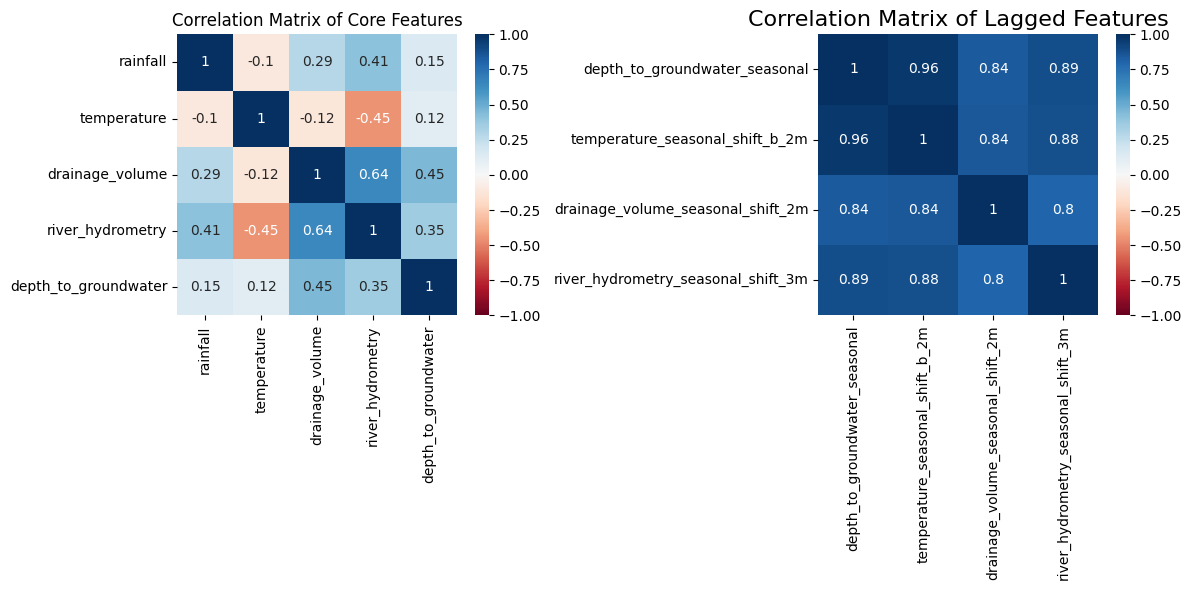

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

corrmat = df[core_columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='RdBu', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=12)

shifted_cols = [
    'depth_to_groundwater_seasonal',         
    'temperature_seasonal_shift_b_2m',
    'drainage_volume_seasonal_shift_2m', 
    'river_hydrometry_seasonal_shift_3m'
]
corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='RdBu', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)


plt.tight_layout()
plt.show()


The chart shows that the lagged features exhibit a much higher level of correlation compared to the original core features. In the "Correlation Matrix of Lagged Features," we observe strong correlations, often above 0.8, between the shifted versions of the seasonal variables. This high correlation may be due to the fact that the shifted features (lags) contain overlapping or related information from previous time periods, resulting in less unique information in each shifted feature.

In contrast, the "Correlation Matrix of Core Features" reveals a more varied correlation pattern, with values ranging from -0.45 to 0.64, indicating a more diverse relationship among the core features, with some positive and negative correlations.

**Key Takeaways:**
1. High Multicollinearity: The lagged features are highly correlated with each other, which could introduce multicollinearity if used in certain models, potentially leading to instability or overfitting in linear models.
2. Potential for Dimensionality Reduction: Since the lagged features are highly correlated, methods such as Principal Component Analysis (PCA) or other dimensionality reduction techniques might help to capture the essential information while reducing redundancy.
3. Feature Selection Consideration: When using lagged features, it might be beneficial to carefully select or combine them to avoid introducing excessive collinearity into the model, particularly if using regression-based approaches.

These insights suggest that, while lagged features are useful for capturing temporal patterns, care must be taken in model construction to avoid redundancy and instability.

### **Autocorrelation Analysis**
ACF and PACF Plots: After making a time series stationary through differencing, the next step in fitting an ARIMA model is to determine whether AR (Auto-Regressive) or MA (Moving Average) terms are needed to correct any remaining autocorrelation in the differenced series. While software like Statgraphics allows you to experiment with different term combinations to find the best fit, there is a more systematic approach. By examining the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots of the differenced series, you can preliminarily identify the number of AR and/or MA terms needed.

- Autocorrelation Function (ACF): The ACF plot helps identify the lag periods (P) to use in the MA component of the ARIMA model. For instance, if 𝑃=3, then the model will use the past three periods in the moving average calculation. The value of 𝑃 corresponds to the MA parameter in ARIMA.
- Partial Autocorrelation Function (PACF): The PACF plot assists in determining the order of differencing (D) needed to make a series stationary (i.e., removing trends or seasonality). 𝐷 represents the number of differencing steps required to transform the series to stationarity and corresponds to the AR parameter in ARIMA.

Autocorrelation plots are especially helpful in detecting seasonality in a time series. By examining the patterns in ACF and PACF plots, you can determine if seasonal or non-seasonal AR and/or MA terms are necessary for the model.

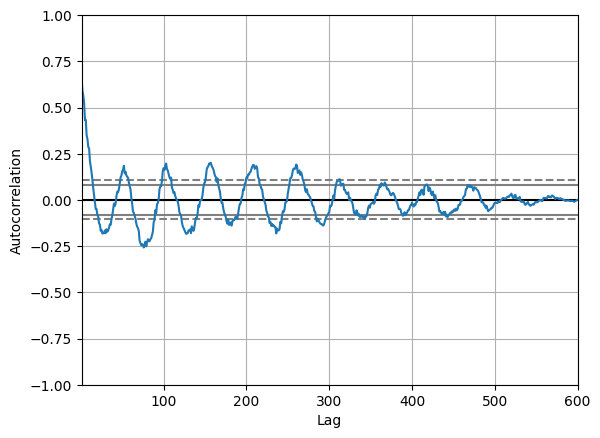

In [32]:
autocorrelation_plot(df['depth_to_groundwater_diff_1'])
plt.show()

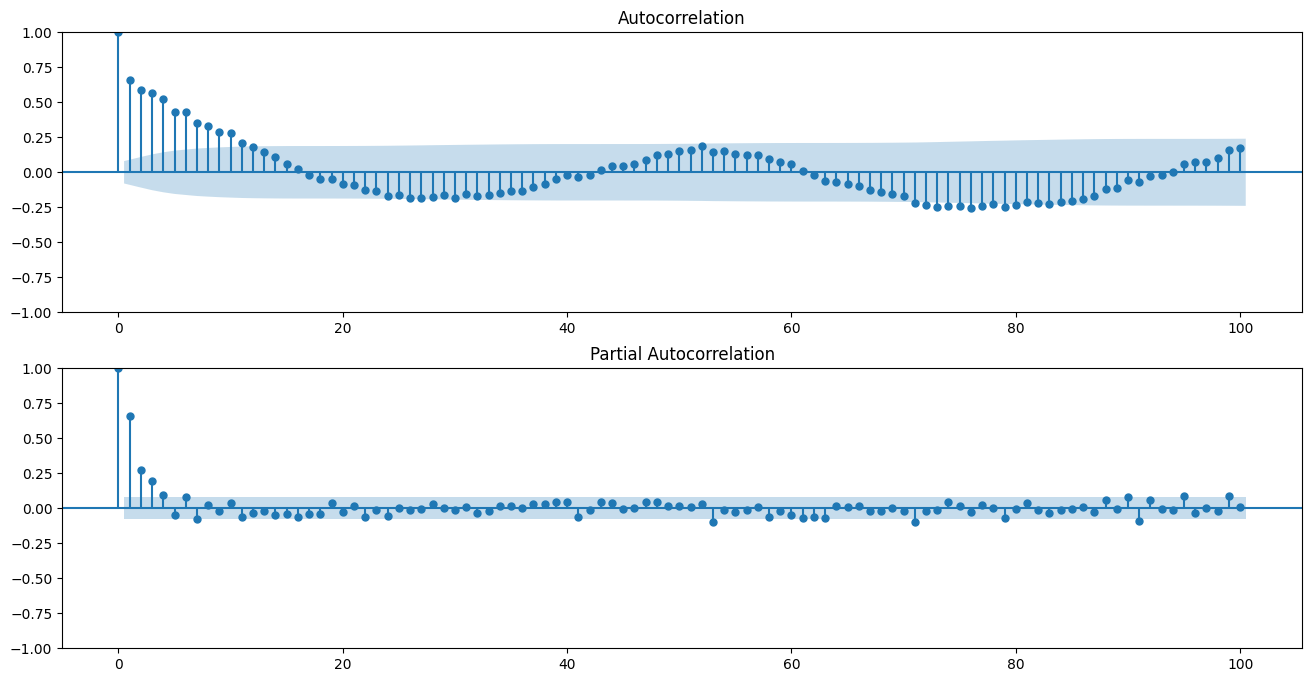

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[0])
plot_pacf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[1])

plt.show()

**Interpretation of the ACF Plot**
- The ACF plot shows the correlation of the series with lagged versions of itself.
- We can see that the ACF starts with a high positive value at lag 0 and gradually declines, oscillating between positive and negative values. This gradual decline over - many lags indicates a strong autocorrelation structure.
- The oscillating pattern in the ACF may suggest the presence of seasonality in the data, with a periodic pattern that extends over several lags.

**Interpretation of the PACF Plot**
- The PACF plot shows the partial correlation of the series with its own lagged values, controlling for the influence of previous lags.
- In this case, the PACF plot has a significant spike at lag 1 and a few minor spikes before quickly decaying to near zero.
- This pattern in the PACF plot suggests that an autoregressive (AR) term might be appropriate in modeling the series.

**Conculsion**
- The ACF plot suggests possible seasonality due to the oscillating pattern. This could indicate that the time series may have a seasonal component.
- The PACF plot suggests the presence of short-term dependencies, potentially fitting an AR model of order 1 (AR(1)).
- Given the ACF and PACF patterns, a seasonal ARIMA model, such as SARIMA, might be appropriate, combining autoregressive terms with seasonal adjustments to capture both the seasonality and short-term dependencies in the data.

### **Modeling**
Time series can be either univariate or multivariate:

- Univariate Time Series: Involves a single time-dependent variable.
- Multivariate Time Series: Involves multiple time-dependent variables.

Before diving into model building, let’s first explore how cross-validation techniques work in time series analysis.

In [34]:
# Split dataset
N_SPLITS = 3

X = df['date']
y = df['depth_to_groundwater']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

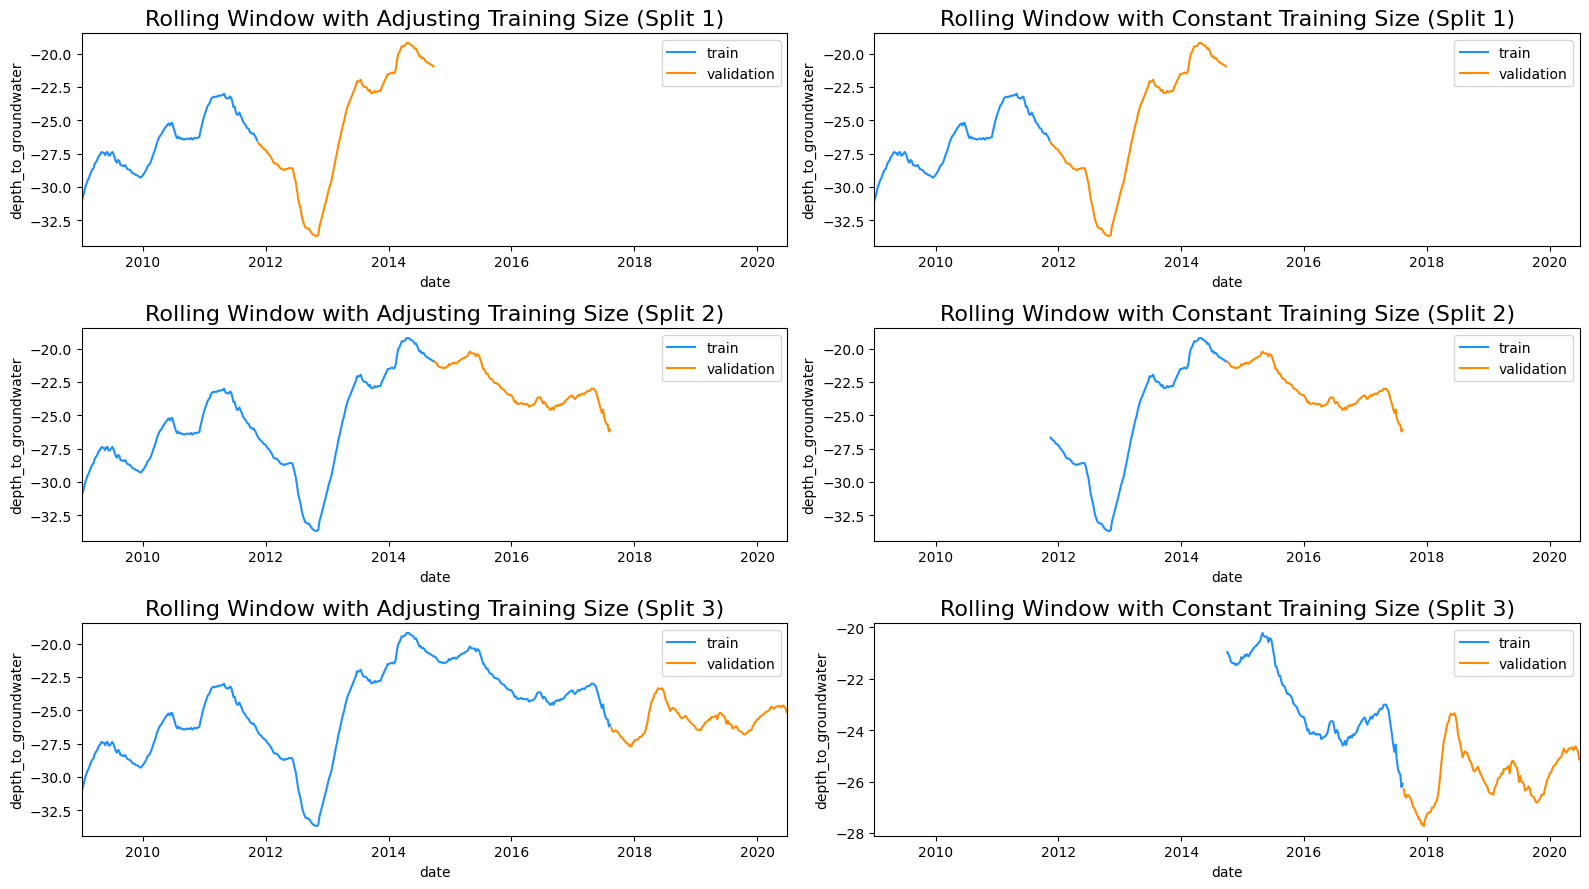

In [37]:
fig, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    # Split the training and validation sets for X and Y
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # Plot the window with adjustable training size
    sns.lineplot(x=X_train, y=y_train, ax=ax[i, 0], color='dodgerblue', label='train')
    sns.lineplot(x=X_valid, y=y_valid, ax=ax[i, 0], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)

    # Plot the window with constant training size (keep only the latest training data)
    sns.lineplot(x=X_train[-len(X_valid):], y=y_train[-len(X_valid):], ax=ax[i, 1], color='dodgerblue', label='train')
    sns.lineplot(x=X_valid, y=y_valid, ax=ax[i, 1], color='darkorange', label='validation')
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

    # Adjust the date range for both charts
    for j in range(2):
        ax[i, j].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()


The idea behind this graph is to understand which training and testing set we are using to tune the model at each iteration.

**Univariate Time Series Models**

To start, let's analyze the forecasting of univariate time series.

Univariate time series: This type of time series involves only one variable that varies over time. For instance, consider data collected from a sensor that measures room temperature every second. In this case, at each time point (each second), there is only a single-dimensional value, which is the temperature.

In [38]:
train_size = int(0.85*len(df))
test_size = len(df) - train_size

univariate_df = df[['date', 'depth_to_groundwater']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train , y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid , y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

510 90


### **Prophet**

The first model we’ll test, which is also capable of handling multivariate problems, is Facebook Prophet.

Prophet, or "Facebook Prophet," is an open-source library developed by Facebook for univariate (single-variable) time series forecasting.

Prophet implements what is known as an additive model for time series forecasting. This model accounts for trends, seasonality, and holiday effects, providing a flexible framework for capturing various patterns in time series data.

In [39]:
# Train model
model = Prophet()
model.fit(train)

# x_valid = model.make_future_dataframe(periods=test_size, freq='w')

# Predict on valid set
y_pred = model.predict(x_valid)

# Calculate metrics
mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

print(f"RMSE: {rmse}")

23:10:05 - cmdstanpy - INFO - Chain [1] start processing
23:10:06 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 1.1648666225418787


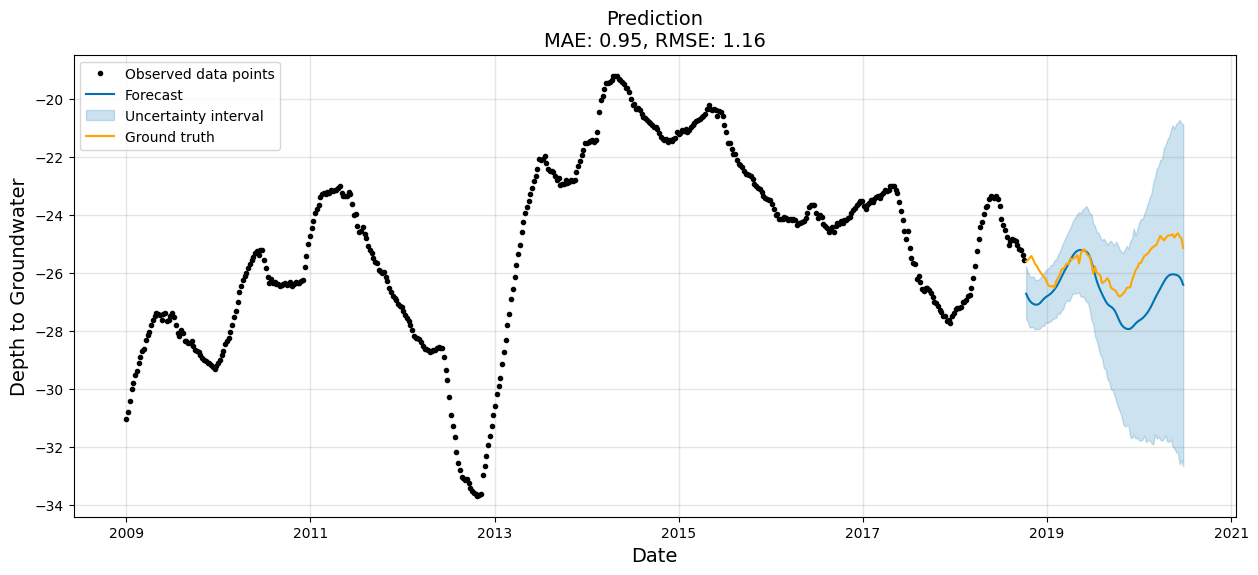

In [40]:
# Plot
fig, ax = plt.subplots(figsize=(15,6))

# Plot prediction
model.plot(y_pred, ax=ax)

# Add line by real values
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth')

# Add titles and labels
ax.set_title(f'Prediction\nMAE: {mae:.2f}, RMSE: {rmse:.2f}', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Depth to Groundwater', fontsize=14)

plt.show()

### **ARIMA**

Steps to Analyze ARIMA
- Step 1 - Check Stationarity: If a time series has a trend or seasonality component, it must be made stationary before using ARIMA for forecasting.
- Step 2 - Differencing: If the time series is not stationary, make it stationary by applying differencing. Take the first difference and check for stationarity. Continue differencing as necessary until the series becomes stationary. Be sure to also check for seasonal differencing if required.
- Step 3 - Split a Validation Sample: This sample will be used to validate the accuracy of our model. Use a train-test validation split to achieve this.
- Step 4 - Select AR and MA Terms: Use the ACF and PACF plots to decide whether to include an AR term, MA term, or both.
- Step 5 - Build the Model: Build the model and set the number of periods to forecast as 𝑁 (depending on your needs).
- Step 6 - Model Validation: Compare the forecasted values with the actual values in the validation sample.

In [41]:
# Fit model
model = ARIMA(y_train, order=(1,1,1))
model_fit = model.fit()

# Prediction with ARIMA
forecast_obj = model_fit.get_forecast(steps=90)
y_pred = forecast_obj.predicted_mean
conf = forecast_obj.conf_int()

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print('RMSE: {}'.format(score_rmse))

RMSE: 1.402615843711107


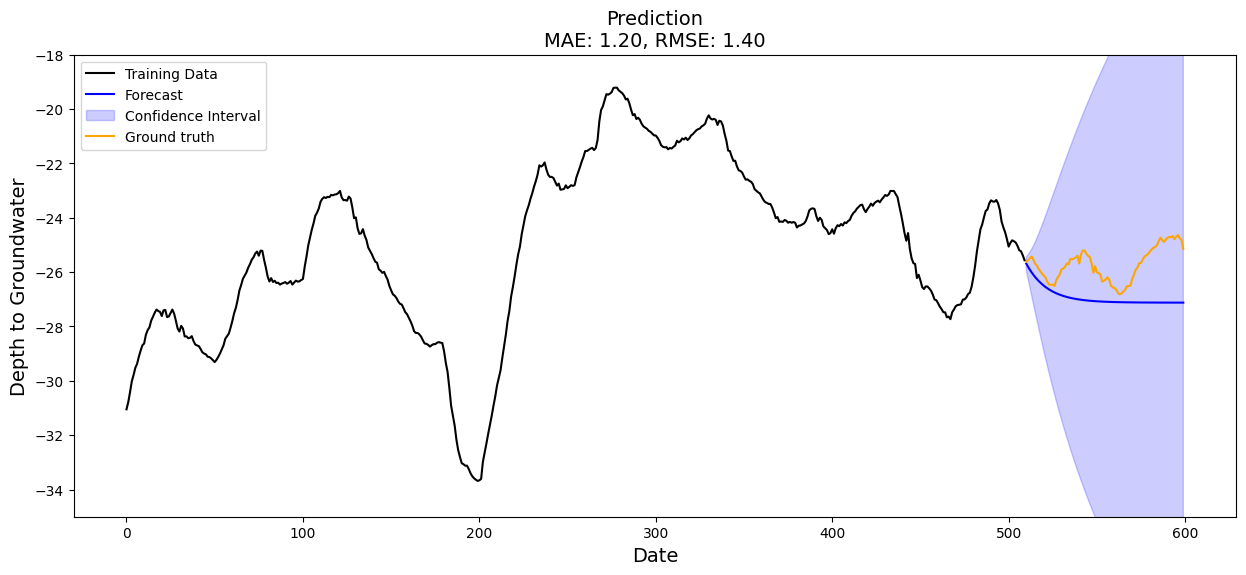

In [42]:
# Realizar la predicción en el rango deseado
# x_valid = x_valid.iloc[-len(y_valid):]

# Configurar la figura y los ejes
f, ax = plt.subplots(1, figsize=(15, 6))

# Graficar los datos históricos (entrenamiento)
ax.plot(y_train.index, y_train, label='Training Data', color='black')

# Graficar la predicción con el intervalo de confianza
y_pred_index = y_valid.index
ax.plot(y_pred_index, y_pred, color='blue', label='Forecast')
ax.fill_between(y_pred_index, conf.iloc[:, 0], conf.iloc[:, 1], color='blue', alpha=0.2, label='Confidence Interval')

# Graficar los datos de validación (Ground truth)
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth')

# Añadir título y etiquetas
ax.set_title(f'Prediction\nMAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Depth to Groundwater', fontsize=14)
ax.set_ylim(-35, -18)

# Mostrar el gráfico
plt.legend()
plt.show()


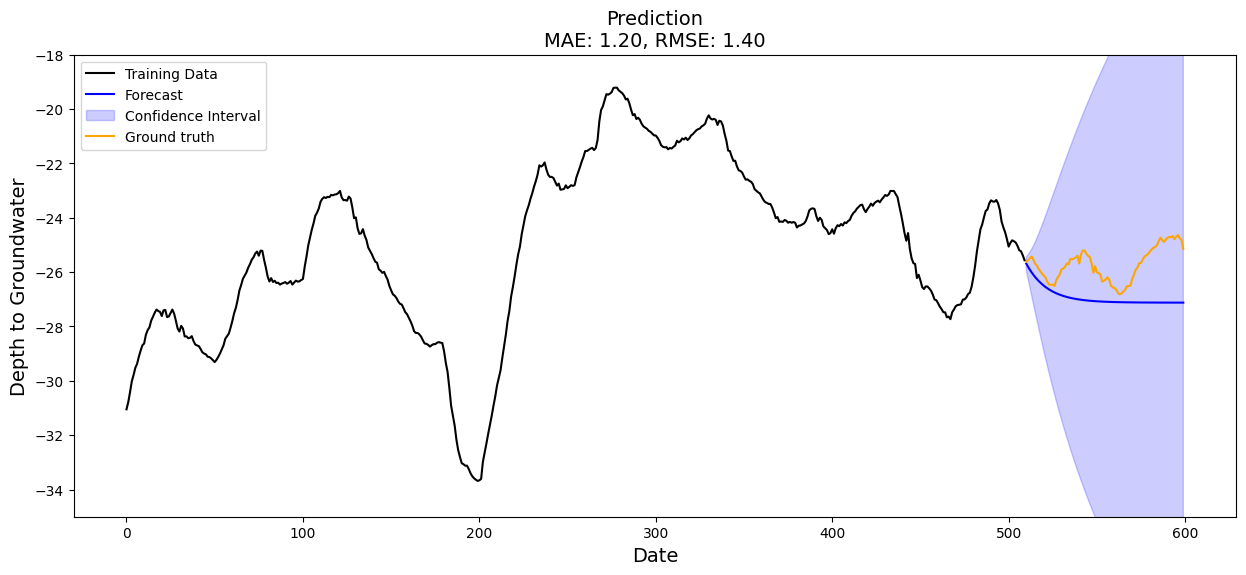

In [43]:
# Realizar la predicción en el rango deseado y configurar los gráficos
f, ax = plt.subplots(1, figsize=(15, 6))

# Graficar los datos históricos (entrenamiento)
ax.plot(y_train.index, y_train, label='Training Data', color='black')

# Graficar la predicción y el intervalo de confianza
y_pred_index = y_valid.index  # Usar el índice de y_valid para alinear predicciones
ax.plot(y_pred_index, y_pred, color='blue', label='Forecast')
ax.fill_between(y_pred_index, conf.iloc[:, 0], conf.iloc[:, 1], color='blue', alpha=0.2, label='Confidence Interval')

# Graficar los datos de validación (Ground truth)
ax.plot(y_valid.index, y_valid['y'], color='orange', label='Ground truth')

# Añadir título y etiquetas
ax.set_title(f'Prediction\nMAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Depth to Groundwater', fontsize=14)
ax.set_ylim(-35, -18)

# Mostrar la leyenda y el gráfico
plt.legend()
plt.show()


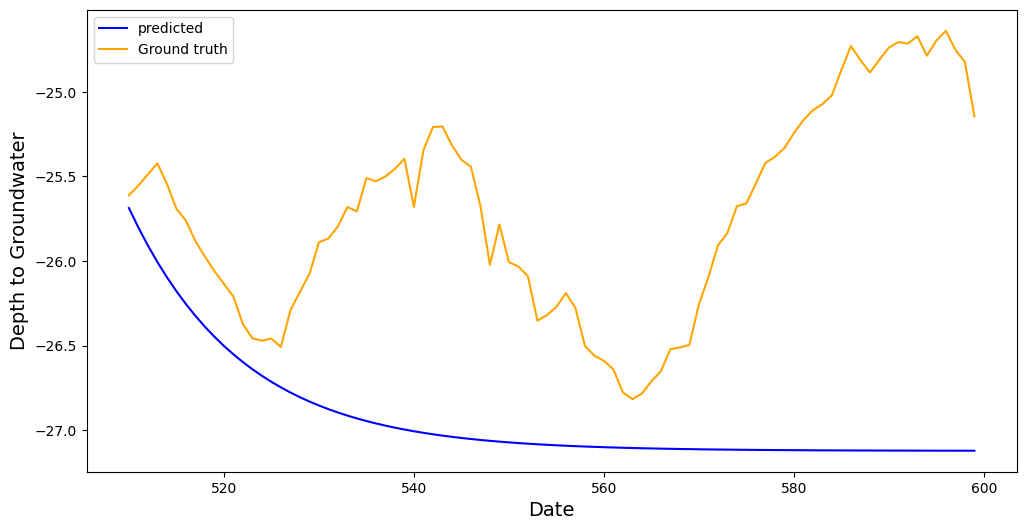

In [44]:
fig, ax = plt.subplots(figsize=(12,6))

sns.lineplot(x=x_valid.index, y=y_pred, ax=ax, color='blue', label='predicted') #navajowhite
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

## **Auto ARIMA**

In [45]:
# Configura los rangos de valores para p, d, y q
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)

# Definir una función para encontrar el mejor modelo
def evaluate_arima_model(data, p, d, q):
    try:
        model = ARIMA(data, order=(p,d,q))
        model_fit = model.fit()
        # Retorna el AIC para evaluar el modelo
        return model_fit.aic
    except:
        return np.inf  # Si el modelo falla, retornar un valor muy alto para ignorarlo

# Seleccionar los mejores parámetros de ARIMA
def auto_arima(data, p_values, d_values, q_values):
    best_aic = np.inf
    best_order = None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                aic = evaluate_arima_model(data, p, d, q)
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
    print(f'Best ARIMA order: {best_order} with AIC: {best_aic}')
    return best_order

# Llamar a la función para encontrar el mejor modelo
best_order = auto_arima(y_train, p_values, d_values, q_values)

# Ajustar el mejor modelo encontrado
model = ARIMA(y_train, order=best_order)
model_fit = model.fit()
print(model_fit.summary())


/workspaces/machine_learning_project_time_series/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/machine_learning_project_time_series/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/machine_learning_project_time_series/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/machine_learning_project_time_series/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregress

/workspaces/machine_learning_project_time_series/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/machine_learning_project_time_series/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/machine_learning_project_time_series/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/machine_learning_project_time_series/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization 

Best ARIMA order: (3, 1, 3) with AIC: -637.7112504258407
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  510
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 325.856
Date:                Mon, 11 Nov 2024   AIC                           -637.711
Time:                        23:11:44   BIC                           -608.084
Sample:                             0   HQIC                          -626.094
                                - 510                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6377      0.173     -3.682      0.000      -0.977      -0.298
ar.L2          0.8033      0.051     15.767      0.000       0.703       0

/workspaces/machine_learning_project_time_series/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


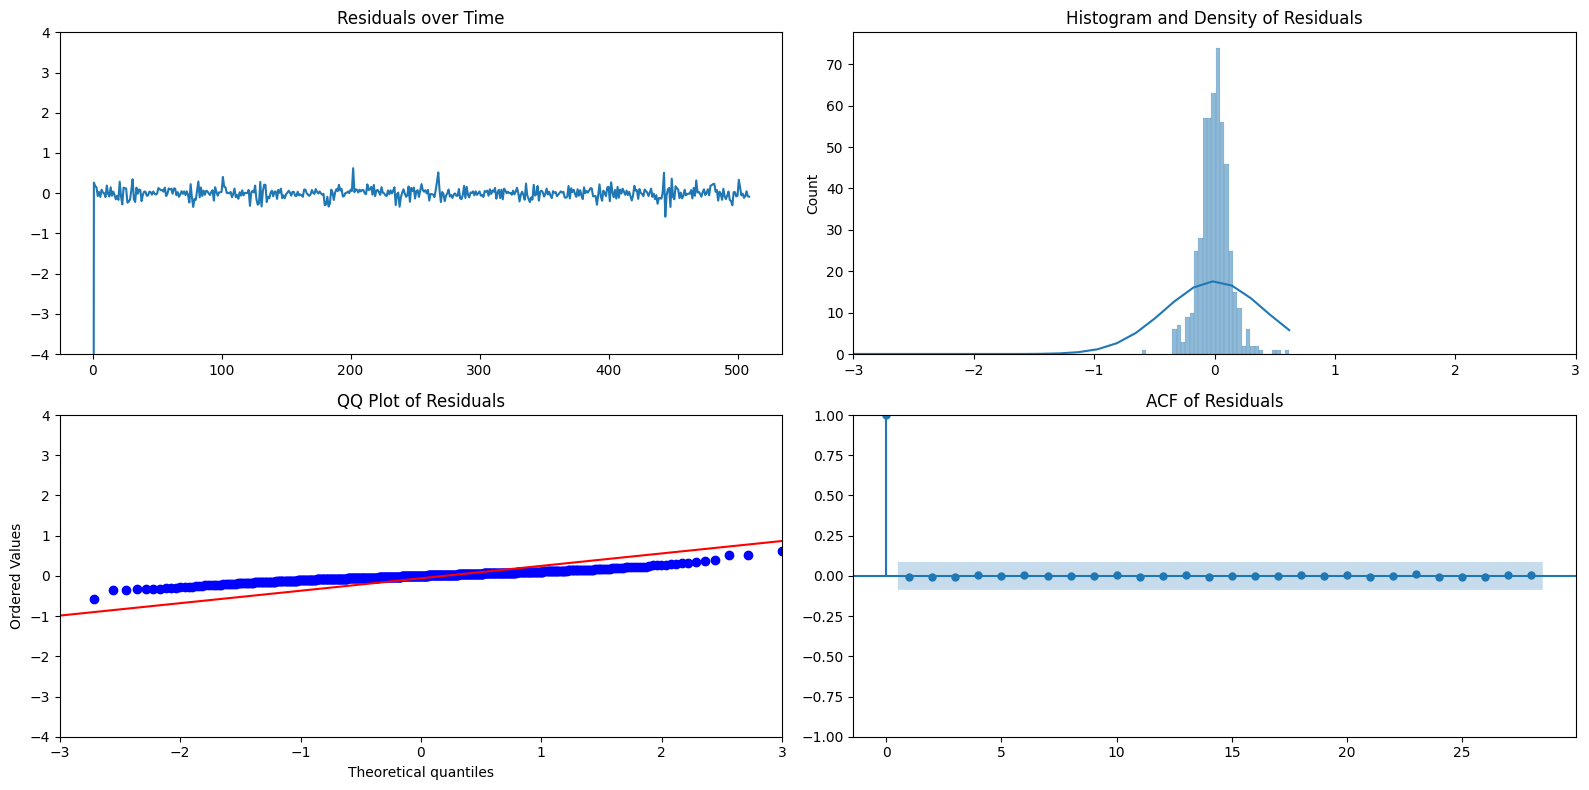

In [46]:
import scipy.stats as stats

# Residuales del modelo
residuals = model_fit.resid

# Crear una figura con 4 subgráficos
fig, axs = plt.subplots(2, 2, figsize=(16, 8))

# Gráfico 1: Residuales en el tiempo
axs[0, 0].plot(residuals)
axs[0, 0].set_title("Residuals over Time")
axs[0, 0].set_ylim(-4, 4)

# Gráfico 2: Histograma y Densidad de los Residuales
sns.histplot(residuals, kde=True, ax=axs[0, 1])
axs[0, 1].set_title("Histogram and Density of Residuals")
axs[0, 1].set_xlim(-3, 3)

# Gráfico 3: QQ-Plot de los Residuales
stats.probplot(residuals, dist="norm", plot=axs[1, 0])
axs[1, 0].set_title("QQ Plot of Residuals")
axs[1, 0].set_ylim(-4, 4)
axs[1, 0].set_xlim(-3, 3)

# Gráfico 4: ACF de los Residuales
plot_acf(residuals, ax=axs[1, 1])
axs[1, 1].set_title("ACF of Residuals")

# Mostrar el gráfico
plt.tight_layout()
plt.show()


**Interpretation of Plots**
- Residuals over Time: Should show a random pattern with no obvious trend.
- Histogram and Density: Residuals should approximate a normal distribution.
- QQ-Plot: Points should line up close to the diagonal line if residuals are normal.
- CF of Residuals: Autocorrelations should be small (ideally, all within the confidence interval) if the model captured the entire autocorrelation structure.

## **LSTM**
We will use a multi-layer Long Short-Term Memory (LSTM) recurrent neural network to predict the last value in a sequence of values.

Before building the LSTM model, the following data preprocessing and feature engineering steps are required:

1. Create the dataset and ensure that all data is in float format.
2. Normalize the features.
3. Split the data into training and test sets.
4. Convert the value matrix into a structured dataset.
5. Reshape data to set 𝑋 = 𝑡 and 𝑌 = 𝑡 + 1.
6. Reshape the input to 3D format: (num_samples, num_timesteps, num_features).

In [47]:
from sklearn.preprocessing import MinMaxScaler

data = univariate_df.filter(['y'])
# Convert the dataframe to a numpy array
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

array([[-0.81796644],
       [-0.79970385],
       [-0.7745311 ],
       [-0.74679171],
       [-0.73099704],
       [-0.71253702],
       [-0.7023692 ],
       [-0.68410661],
       [-0.66890424],
       [-0.65528134]])

In [48]:

# Defines the rolling window
look_back = 52
# Split into train and test sets
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

406 90


In [49]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_test, y_test))

model.summary()

Epoch 1/5


2024-11-11 23:13:07.679790: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/workspaces/machine_learning_project_time_series/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


406/406 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0257 - val_loss: 7.9400e-04
Epoch 2/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0021 - val_loss: 9.6000e-04
Epoch 3/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0038 - val_loss: 7.7332e-04
Epoch 4/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 3.3566e-04
Epoch 5/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 5.9011e-04


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 431,195 (1.64 MB)

 Trainable params: 143,731 (561.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 287,464 (1.10 MB)

In [50]:
# Let's predict with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))

test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
score_mae = mean_absolute_error(y_test, test_predict)
print('RMSE: {}'.format(score_rmse))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RMSE: 0.3515411457933782


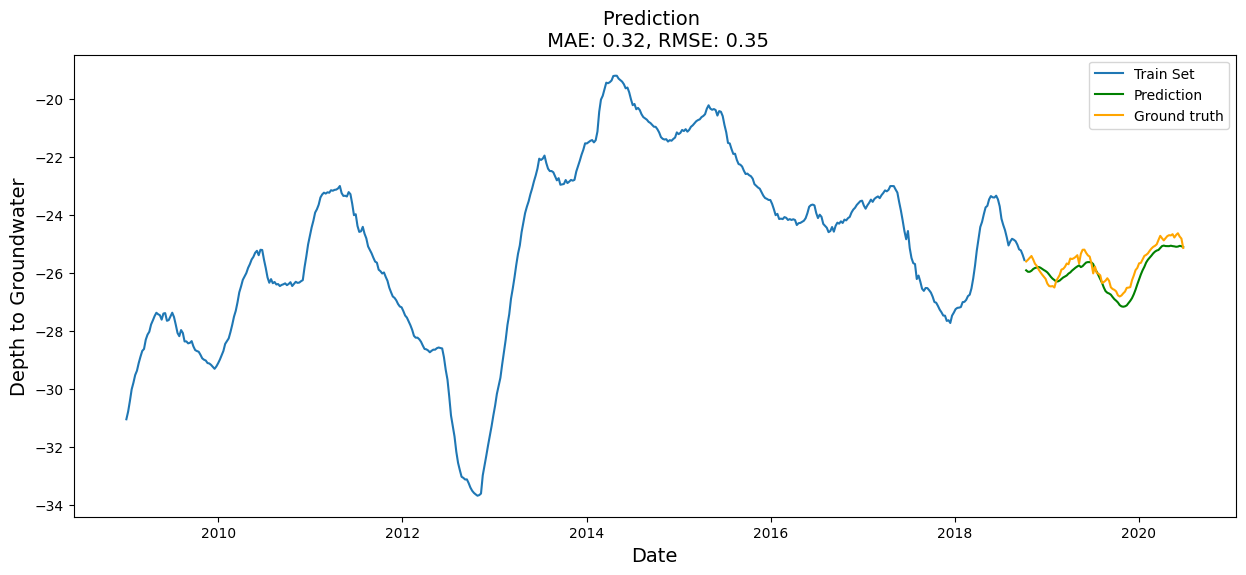

In [51]:
# Definir los índices de tiempo para el conjunto de entrenamiento y de prueba
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

# Ajustar la forma de y_test si es necesario para asegurar compatibilidad con test_predict
y_test = y_test.reshape(-1, 1)  # Convertir y_test a 2D si es necesario

# Graficar el pronóstico
f, ax = plt.subplots(1, figsize=(15, 6))

# Gráficos de líneas para los conjuntos de entrenamiento, predicción y prueba
sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set')
sns.lineplot(x=x_test_ticks, y=test_predict[:, 0], ax=ax, color='green', label='Prediction')
sns.lineplot(x=x_test_ticks, y=y_test[:, 0], ax=ax, color='orange', label='Ground truth')

# Configurar el título y etiquetas
ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Depth to Groundwater', fontsize=14)

# Mostrar el gráfico
plt.show()

## **Multivariate Time Series Models**

Finally, we will analyze multivariate time series forecasting.

Multivariate time series: In this type of time series, multiple variables vary over time. For example, consider a triaxial accelerometer, which records acceleration along three axes (x, y, z). Each axis has its own acceleration values, and all vary simultaneously over time.

In [52]:
feature_columns = [
    'rainfall',
    'temperature',
    'drainage_volume',
    'river_hydrometry',
]
target_column = ['depth_to_groundwater']

train_size = int(0.85 * len(df))

multivariate_df = df[['date'] + target_column + feature_columns].copy()
multivariate_df.columns = ['ds', 'y'] + feature_columns

train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

,ds,y,rainfall,temperature,drainage_volume,river_hydrometry
0,2009-01-01,-31.048571,0.000000,1.657143,-28164.918857,2.371429
1,2009-01-08,-30.784286,0.285714,4.571429,-29755.789714,2.314286
2,2009-01-15,-30.420000,0.028571,7.528571,-25463.190857,2.300000
3,2009-01-22,-30.018571,0.585714,6.214286,-23854.422857,2.500000
4,2009-01-29,-29.790000,1.414286,5.771429,-25210.532571,2.500000


In [53]:
# Train the model
model = Prophet()
model.add_regressor('rainfall')
model.add_regressor('temperature')
model.add_regressor('drainage_volume')
model.add_regressor('river_hydrometry')

# Fit the model with train set
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print('RMSE: {}'.format(score_rmse))

23:16:57 - cmdstanpy - INFO - Chain [1] start processing
23:16:58 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.9806231219261384


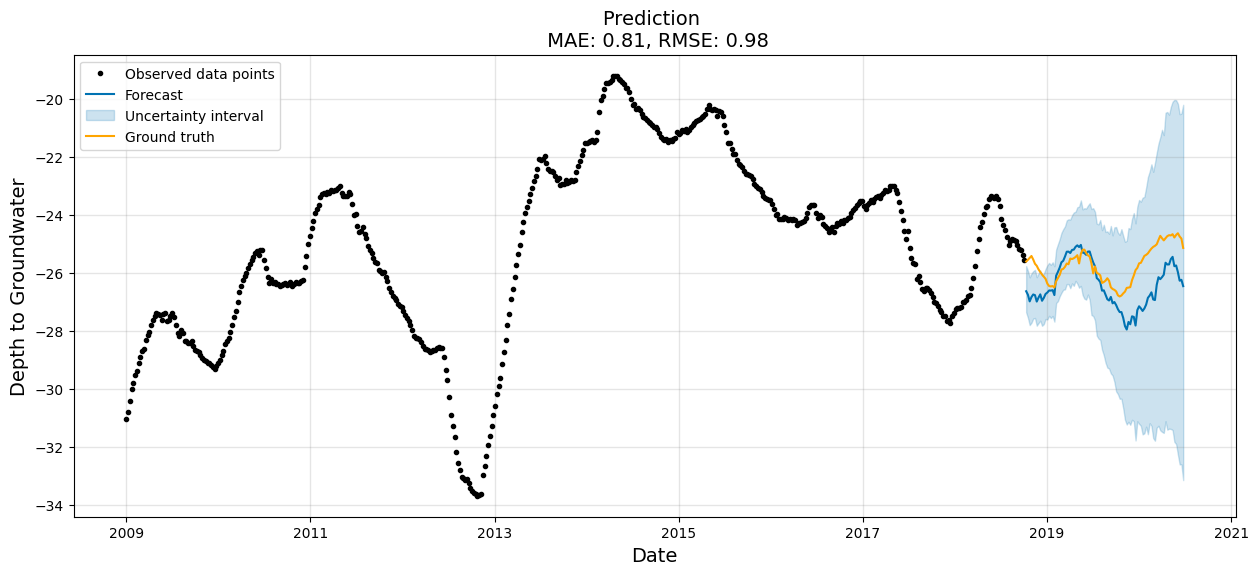

In [54]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

## **References**

Aquí voy a referenciar algunos enlaces útiles que he utilizado para construir este cuaderno

- Referencia especial para la información útil y los gráficos - https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting
- ARIMA - https://towardsdatascience.com/time-series-forecasting-arima-models-7f221e9eee06
- Auto-ARIMA - https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
- Keras LSTM - https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
- Profeta - https://towardsdatascience.com/time-series-prediction-using-prophet-in-python-35d65f626236
- Referencia especial - https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting/notebook#Models
- Características cíclicas - https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca
- ADF - https://medium.com/@cmukesh8688/why-is-augmented-dickey-fuller-test-adf-test-so-important-in-time-series-analysis-6fc97c6be2f0
- ACF/PACF - https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8
- LSTM - https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba